# Tutorial 4.2 Thinking with Deep Learning: Week 4 Part 2
# Active, Adaptive, and Continuous Learning 

__Instructor:__ James Evans

__Notebook Author:__ Bhargav Srinivasa Desikan

__Teaching Assistants & Course Organizers:__ Likun Cao & Partha Kadambi 


# Active Learning

(from the [Active Learning handbook](http://burrsettles.com/pub/settles.activelearning.pdf))

The key idea behind active learning is that machine learning algorithms--including our deep models--can
achieve greater accuracy with fewer training labels if they are allowed to choose the data from which they learn. An active learner may pose queries, usually in the form of unlabeled data instances to be labeled by an oracle (e.g., a human annotator). Active learning is well-motivated in many modern machine learning problems, where unlabeled data may be abundant or easily obtained, but labels are difficult, time-consuming, or expensive to obtain. Consider the case you want to build a deep model that predicts a distinctive expert (e.g., a "Thumbs Up" rating from the now-deceased Pulitzer Prize winning film critic Roger Ebert; the diagnostic assessment of an M.D. radiologist from an X-ray). Active learning allows us to actively and adaptively customize our sample to maximize generalizability.

Here are some useful links on Active Learning we recommend:

- [Robert Munroe Active Learning with PyTorch](https://medium.com/pytorch/https-medium-com-robert-munro-active-learning-with-pytorch-2f3ee8ebec)

- [Robert Munroe's Human in the Loop Learning code](https://github.com/rmunro/pytorch_active_learning)

- [Human-in-the-Loop Methods for Data-Driven and Reinforcement Learning Systems](https://arxiv.org/abs/2008.13221)

- [Google Active Learning code](https://github.com/google/active-learning)

To illustrate Active Learning, we will be using the python package [modAL-python](https://github.com/modAL-python/modAL), which contains extensive documentation with examples. 





In [1]:
! pip install modAL

## Interactive labeling with Jupyter

In this example, the active learning workflow of modAL is demonstrated - with you in the loop! By running this notebook, you'll be queried to label digits using the [DIGITS dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits). If you would like to try this out, you can [download this notebook here](https://github.com/modAL-python/modAL/blob/master/docs/source/content/examples/interactive_labeling.ipynb)!

In [2]:
import sklearn.ensemble

In [3]:
import numpy as np

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, entropy_sampling, margin_sampling

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

### The dataset

Now we set up the initial training set for our classifier. If you would like to play around, you can try to modifiy the value ```n_initial``` below and see if it impacts the algorithm!

In [4]:
n_initial = 100

In [5]:
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)

X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)

### Initializing the learner

Now we initialize the active learner, using the multi-layer perceptron (```MLPClassifier```), which you can change to any deep or machine learning algorithm (most easily in sklearn), and the ```uncertainty_sampling``` approach to acquiring new samples to a wide menu of approaches!

For example, if you want to benchmark your deep learning algorithm, you might consider ```RandomForestClassifier```,```AdaBoostClassifier``` or the ```KNearestNeighborClassifier``` as underlying model estimators. 

Based on your estimator, consider trying other "acquisition" approaches, including a ```entropy_sampling``` or ```margin_sampling``` query strategy, all discussed in greater detail below and all based on an uncertainty-resolving logic. Read about these and other options [**here**](https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html). 


In [6]:
learner = ActiveLearner(
    estimator=MLPClassifier(),
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)

We also set how many queries we want to make. Typically the more the better (but based on our research budget)! 

In [7]:
n_queries = 20

### The active learning loop

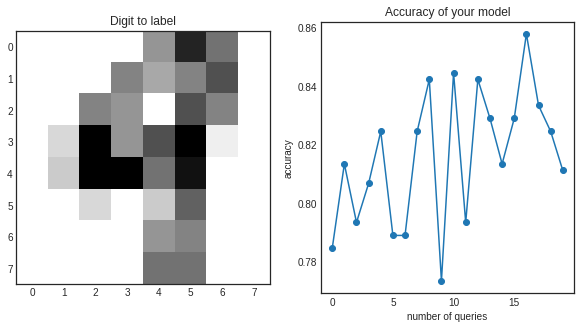

Which digit is this?
4


In [8]:
accuracy_scores = [learner.score(X_test, y_test)]

for i in range(n_queries):
    display.clear_output(wait=True)
    query_idx, query_inst = learner.query(X_pool)
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Digit to label')
        plt.imshow(query_inst.reshape(8, 8))
        plt.subplot(1, 2, 2)
        plt.title('Accuracy of your model')
        plt.plot(range(i+1), accuracy_scores)
        plt.scatter(range(i+1), accuracy_scores)
        plt.xlabel('number of queries')
        plt.ylabel('accuracy')
        display.display(plt.gcf())
        plt.close('all')
        
    print("Which digit is this?")
    y_new = np.array([int(input())], dtype=int)
    learner.teach(query_inst.reshape(1, -1), y_new)
    X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    accuracy_scores.append(learner.score(X_test, y_test))

Finally, we can visualize the accuracy during training.

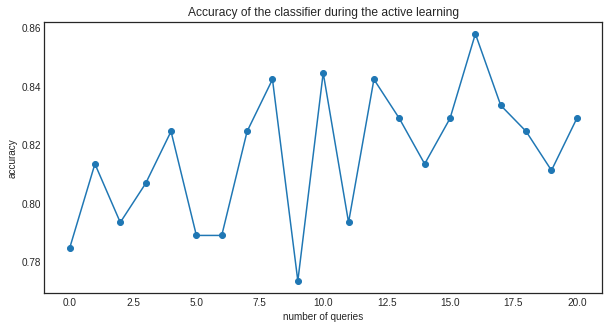

In [9]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of the classifier during the active learning')
    plt.plot(range(n_queries+1), accuracy_scores)
    plt.scatter(range(n_queries+1), accuracy_scores)
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.show()

## Uncertainty sampling


When you present unlabelled examples to an active learner, it finds you the most *useful* example and presents it to be labelled. This is done by first calculating the *usefulness* of each example for prediction and resolution of model uncertainty, then selecting an instance based on that usefulness. As suggested above, there are several ways to measure this based on classification uncertainty called *uncertainty measures*. 


Some of the popular ones (as covered in this [cheatsheet](https://towardsdatascience.com/uncertainty-sampling-cheatsheet-ec57bc067c0b)) include:

- Least Confidence: difference between the most confident prediction and 100% confidence ([modAL.uncertainty.uncertainty_sampling](https://modal-python.readthedocs.io/en/latest/_modules/modAL/uncertainty.html#uncertainty_sampling))
- Margin of Confidence: difference between the top two most confident predictions ([modAL.uncertainty.margin_sampling](https://modal-python.readthedocs.io/en/latest/_modules/modAL/uncertainty.html#margin_sampling))
- Entropy: difference between all predictions, as defined by information theory ([modAL.uncertainty.entropy_sampling](https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html#modAL.uncertainty.margin_sampling))

The modAL package has a list of its various uncertainty sampling methods [here in the documentation](https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html).

Three such popular measures are *classification uncertainty*, *classification margin* and *classification entropy*. In this quick tutorial, we are going to review them. For more details, see Section 2.3 of the awesome book [Active learning by Burr Settles](http://active-learning.net/)!

**In the section on Pool-based sampling, we will see how we can toggle these different methods for an example with real data.**

In [10]:
import numpy as np

### Classification uncertainty


The simplest measure is uncertainty of classification defined by

$$U(x)=1-P(\hat{x}|x)$$

where $x$ is the instance to be predicted and $\hat{x}$ is the most likely prediction.

For example, if you have classes ``[0, 1, 2]`` and classification probabilities ``[0.1, 0.2, 0.7]``, the most likely class according to the classifier is ``2`` with uncertainty 0.3. If you have three instances with class probabilities

In [11]:
proba = np.array([[0.65, 0.15, 0.20],
                  [0.609 , 0.3 , 0.091 ],
                  [0.39, 0.61, 0.0 ]])

the corresponding uncertainties are:

In [12]:
1 - proba.max(axis=1)

array([0.35 , 0.391, 0.39 ])

In the above example, the most uncertain sample is the second one. When
querying for labels based on this measure, the strategy selects the
sample with highest uncertainty.

For this ternary classification problem, given the first two
probabilities, the classification uncertainty looks as follows.

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import product
n_res = 100
p1, p2 = np.meshgrid(np.linspace(0, 1, n_res), np.linspace(0, 1, n_res))
p3 = np.maximum(1 - p1 - p2, 0)

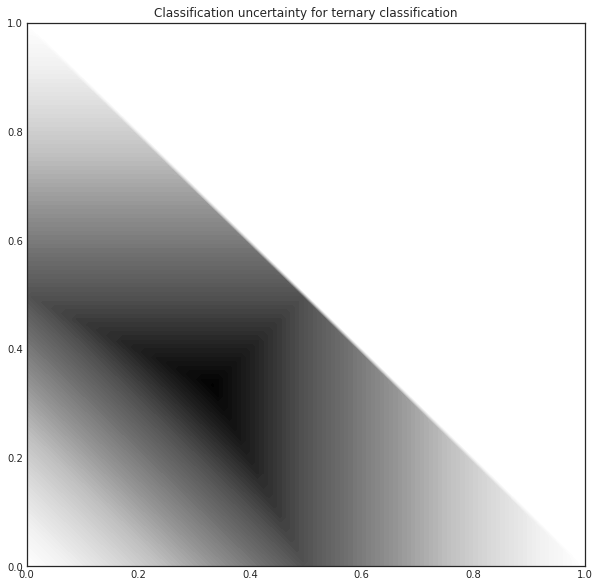

In [14]:
uncertainty = 1 - np.maximum.reduce([p1, p2, p3])

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    plt.contourf(p1, p2, uncertainty*((p1+p2) < 1), 100)
    plt.title('Classification uncertainty for ternary classification')

### Classification margin


Classification margin is the difference in probability of the first and second most likely prediction, defined by

$$M(x)=P(\hat{x_1}|x)-P(\hat{x_2}|x)$$

where $\hat{x_1}$ and $\hat{x_2}$ are the first and second most likely classes. Using the same example we used for classification uncertainty, if the class probabilities are

In [15]:
proba = np.array([[0.65, 0.15, 0.20],
                  [0.609 , 0.3 , 0.091 ],
                  [0.39, 0.61, 0.0 ]])

corresponding margins are:

In [16]:
part = np.partition(-proba, 1, axis=1)
margin = - part[:, 0] + part[:, 1]

In [17]:
margin

array([0.45 , 0.309, 0.22 ])

When querying for labels, the strategy selects the sample with the *smallest* margin, since the smaller the decision margin, the more unsure the decision. In this case, it would be the third sample. For this ternary classification problem, the classifier margin plotted against the first two probabilities are as follows:

In [18]:
proba = np.vstack((p1.ravel(), p2.ravel(), p3.ravel())).T

part = np.partition(-proba, 1, axis=1)
margin = - part[:, 0] + part[:, 1]

margin = margin.reshape(p1.shape)

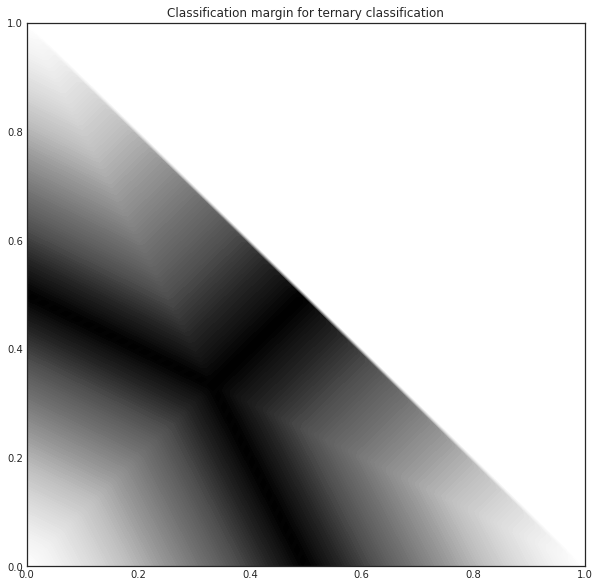

In [19]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    plt.contourf(p1, p2, (1-margin)*((p1+p2) < 1), 100)
    plt.title('Classification margin for ternary classification')

### Classification entropy


The third built-in uncertainty measure is the classification entropy, defined by

$$H(x)=-\sum_{k}p_k\log(p_k)$$

where $p_k$ is the probability of the sample belonging to the $k$-th class. Heuristically, the entropy is proportional to the average number of guesses one has to make to find the true class. In our usual example:

In [20]:
proba = np.array([[0.65, 0.15, 0.20],
                  [0.609 , 0.3 , 0.091 ],
                  [0.39, 0.61, 0.0 ]])

the corresponding entropies are

In [21]:
from scipy.stats import entropy

entropy(proba.T)

array([0.88646448, 0.881335  , 0.66874809])

The closer the distribution to uniform, the larger the entropy. Again, if we plot the entropy against the first two probabilities of a ternary classification problem, we obtain the following.

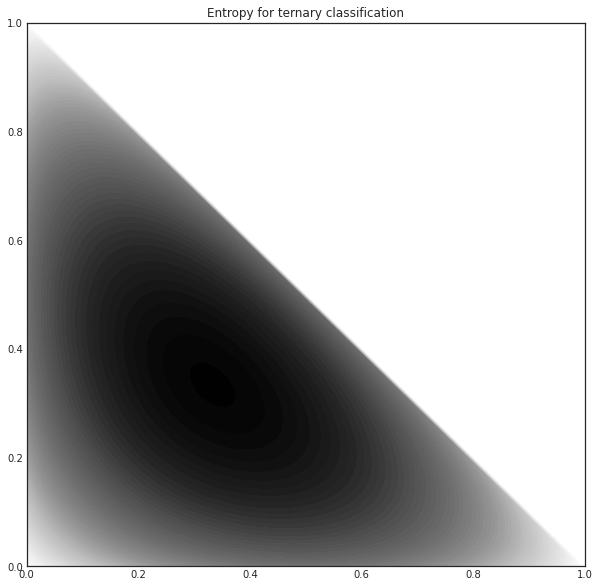

In [22]:
proba = np.vstack((p1.ravel(), p2.ravel(), p3.ravel())).T
entr = entropy(proba.T).reshape(p1.shape)

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 10))
    plt.contourf(p1, p2, entr*((p1+p2) < 1), 100)
    plt.title('Entropy for ternary classification')

## Information density


When using uncertainty sampling (or similar strategies), we are unable to take the structure of the data into account. This can lead to suboptimal queries where we select data points for labeling where the model is uncertain, but the data is sparse (i.e., the data points are outliers and there may be fundmamental uncertainty about them). To alleviate this, one method is to use information density measures to help us guide our queries, allows us to balance uncertainty with representativeness.

For an unlabeled dataset $X_{u}$, the information density of an instance $x$ can be calculated as

$$ I(x) = \frac{1}{|X_{u}|} \sum_{x^\prime \in X} sim(x, x^\prime),$$

where $sim(x, x^\prime)$ is a similarity function such as [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) or Euclidean similarity--the reciprocal of [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance). The higher the information density, the more similar the given instance is to the rest of the data. To illustrate this, we shall use a simple synthetic dataset.

For more details, see Section 5.1 of the [Active Learning book by Burr Settles](https://www.morganclaypool.com/doi/abs/10.2200/S00429ED1V01Y201207AIM018)!

In [23]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_features=2, n_samples=1000, centers=3, random_state=0, cluster_std=0.7)

In [24]:
from modAL.density import information_density

cosine_density = information_density(X, 'cosine')
euclidean_density = information_density(X, 'euclidean')

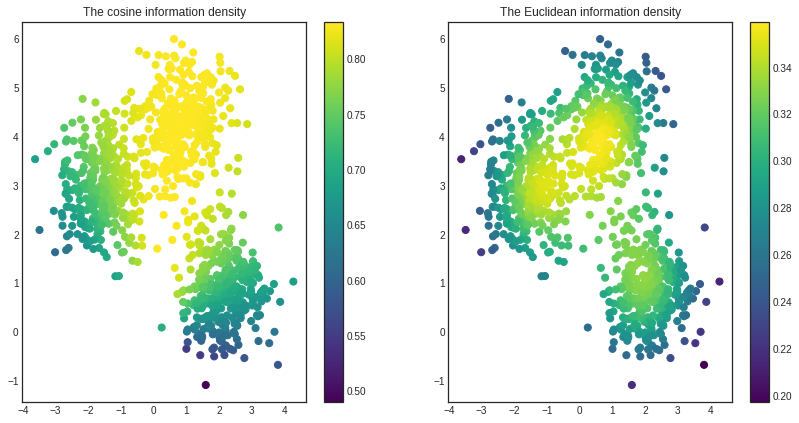

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

# visualizing the cosine and euclidean information density
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.scatter(x=X[:, 0], y=X[:, 1], c=cosine_density, cmap='viridis', s=50)
    plt.title('The cosine information density')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.scatter(x=X[:, 0], y=X[:, 1], c=euclidean_density, cmap='viridis', s=50)
    plt.title('The Euclidean information density')
    plt.colorbar()
    plt.show()

As you can see, different similarity functions highlight distinct features of the dataset. The Euclidean information density prefers the center of clusters, while the cosine describes the middle cluster as most important.

Now we contrast different approaches to active sampling that draw upon both principles of Uncertainty and Information Density, and which vary in how data is received and decisions for querying are made: **pool-based**, **(ranked) batch-mode**, and **stream-based**. In pool-based, all unlabeled cases exist in a pre-existing pool and queries are made one-by-one. In batch-mode, multiple queries are made together (the batch), and they are individually ranked for prioritization. In stream-mode, cases face the learner one-by-one, which must decide whether to label or not.

## Pool-based sampling

### Overview

In this example, we apply an `ActiveLearner` onto the iris dataset using pool-based sampling. In this setting, we assume a small set of labeled data $\mathcal{L}$ and a large set of unlabeled data $\mathcal{U}$ such that $\left| \mathcal{L} \right| \ll \left| \mathcal{U} \right|$. In his review of the active learning literature, Settles covers a high-level overview of the general pool-based sampling algorithm:

> Queries are selectively drawn from the pool, which is usually assumed to be closed (i.e., static or non-changing), although this is not strictly necessary. Typically, instances are queried in a greedy fashion, according to an informativeness measure used to evaluate all instances in the pool (or, perhaps if $\mathcal{U}$ is very large, some subsample thereof).

Along with our pool-based sampling strategy, `modAL`'s modular design allows you to vary parameters surrounding the active learning process, including the core estimator and query strategy. In this example, we use `scikit-learn`'s Neural Network - a [Multi Layer Preceptron Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) as our estimator and default to `modAL`'s [uncertainty sampling](https://cosmic-cortex.github.io/modAL/Uncertainty-sampling) query strategy.

For further reading on pool-based sampling, we highly recommend the following resources:
- Burr Settles. [Active Learning Literature Survey](http://burrsettles.com/pub/settles.activelearning.pdf) [**Section 2.3: Pool-based Sampling**]. Computer Sciences Technical Report 1648, University of Wisconsin-Madison. 2009.

To enforce a reproducible result across runs, we set a random seed.

In [26]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

### The dataset

Now we load the dataset. In this example, we are going to use the famous Iris dataset--a dataset of different iris flowers measured by sepal length and width and petal length and width. For more information on the iris dataset, see:
  - [The dataset documentation on Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set)
  - [The scikit-learn interface](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html)

In [27]:
from sklearn.datasets import load_iris

iris = load_iris()
X_raw = iris['data'] 
y_raw = iris['target']

For visualization purposes, we apply PCA to the original dataset.

In [28]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)

This is how the dataset looks:

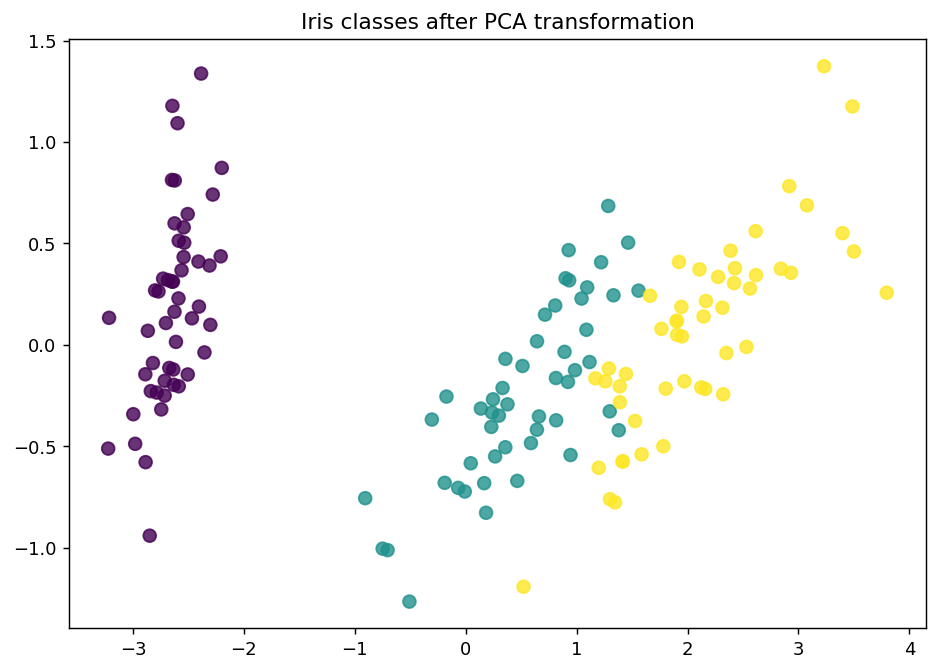

In [29]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Iris classes after PCA transformation')
plt.show()

Now we partition our `iris` dataset into a training set $\mathcal{L}$ and $\mathcal{U}$. We first specify our training set $\mathcal{L}$ consisting of 3 random examples. The remaining examples go to our "unlabeled" pool $\mathcal{U}$.

In [30]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

### Active learning with pool-based sampling

For the underlying classification, we are going to use a simple k-nearest neighbors classifier. First, we must initialize the ```ActiveLearner```.

**NOTE**: here we use uncertainty sampling as our query strategy, which is the default sampling strategy; you are encouraged to also try out margin sampling and entropy sampling

**NOTE**: modAL primarily works with scikit-learn, while also offering support for Keras and PyTorch wrappers (which you will see at the end of the section). This is why in the examples we see scikit-learn instead of the other models we've been seeing so far.



In [31]:
from modAL.uncertainty import uncertainty_sampling, entropy_sampling, margin_sampling

In [32]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

In [33]:
simplefilter("ignore", category=ConvergenceWarning)

In [34]:
from sklearn.neural_network import MLPClassifier
from modAL.models import ActiveLearner

# Specify our core estimator along with it's active learning model.
mlp = MLPClassifier()
# we can set out our query strategy here!
learner = ActiveLearner(estimator=mlp, X_training=X_train, y_training=y_train, query_strategy=uncertainty_sampling)

Let's see how our classifier performs on the initial training set!

In [35]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

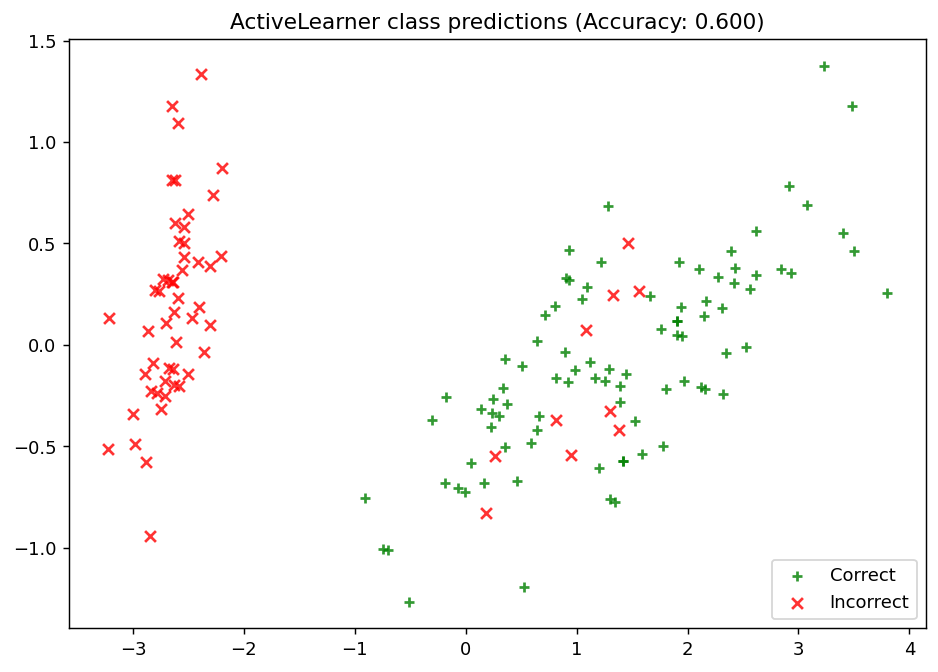

In [36]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

### Update our model by pool-based sampling our "unlabeled" dataset $\mathcal{U}$

As we can see, our model is unable to properly learn the underlying data distribution. All of its predictions are for the third class label, and as such it is only as competitive as defaulting its predictions to a single class – if only we had more data!

Below, we tune our classifier by allowing it to query 20 instances it hasn't seen before. Using uncertainty sampling, our classifier aims to reduce the amount of uncertainty in its predictions using a variety of measures — see the documentation for more on specific [classification uncertainty measures](https://modal-python.readthedocs.io/en/latest/content/query_strategies/Uncertainty-sampling.html). With each requested query, we remove that record from our pool $\mathcal{U}$ and record our model's accuracy on the raw dataset.

In [37]:
N_QUERIES = 20
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)
  
  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X, y=y)
  
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
  
  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw, y_raw)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
  
  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.6067
Accuracy after query 2: 0.6200
Accuracy after query 3: 0.5200
Accuracy after query 4: 0.6000
Accuracy after query 5: 0.3333
Accuracy after query 6: 0.9600
Accuracy after query 7: 0.9733
Accuracy after query 8: 0.9800
Accuracy after query 9: 0.9800
Accuracy after query 10: 0.9467
Accuracy after query 11: 0.9800
Accuracy after query 12: 0.9600
Accuracy after query 13: 0.9733
Accuracy after query 14: 0.9667
Accuracy after query 15: 0.9800
Accuracy after query 16: 0.9733
Accuracy after query 17: 0.9800
Accuracy after query 18: 0.9867
Accuracy after query 19: 0.9800
Accuracy after query 20: 0.9800


### Evaluate our model's performance

Here, we first plot the query iteration index against model accuracy. To visualize the performance of our classifier, we also plot correct and incorrect predictions on the full dataset.

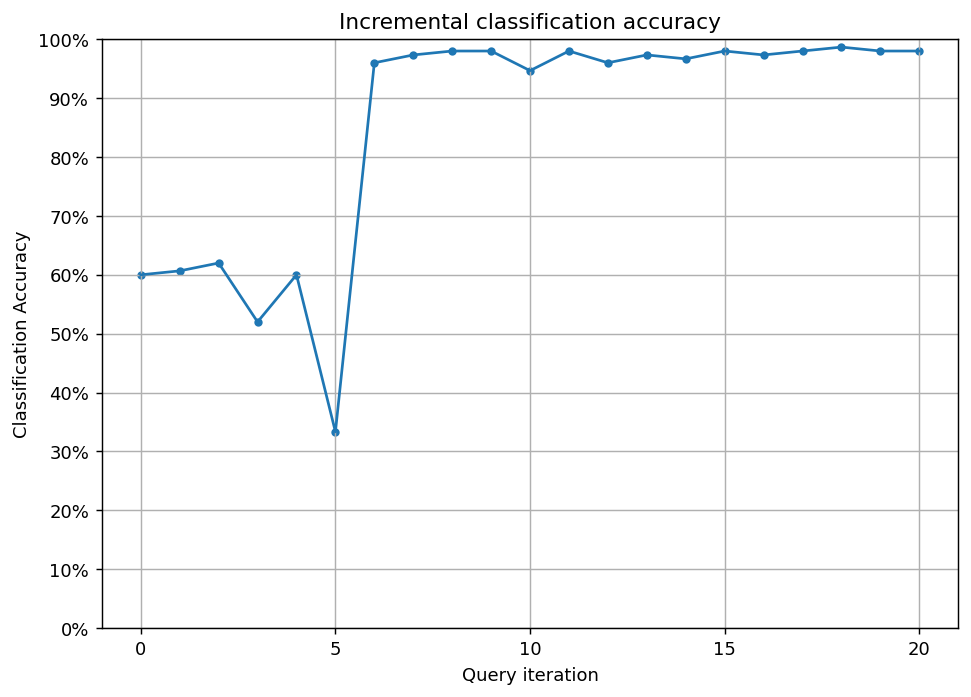

In [38]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

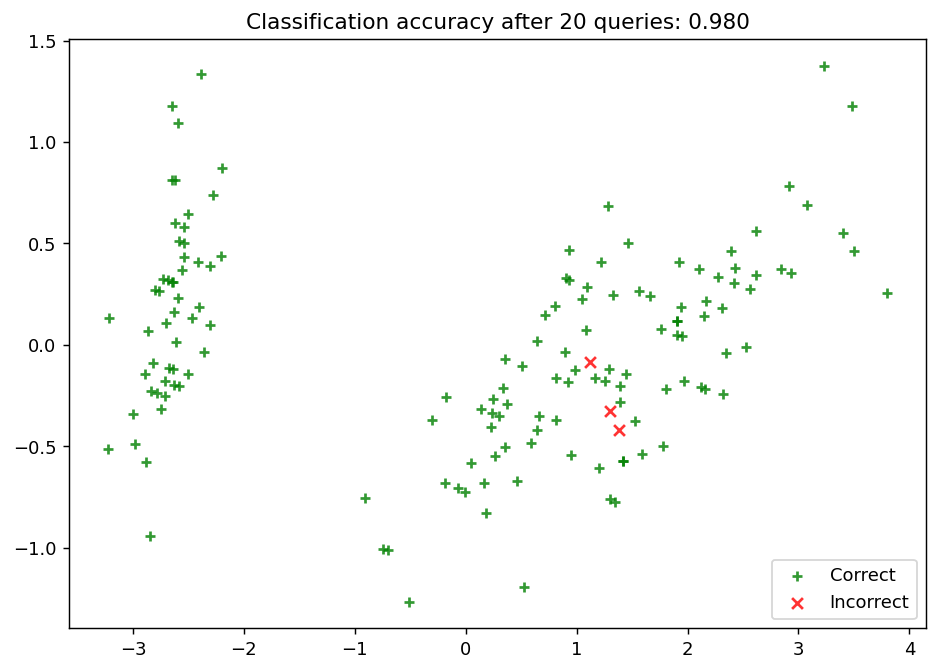

In [39]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

## Ranked batch-mode sampling


When querying from unlabeled data, sometimes you have the resources or requirement to label multiple instances at the same time. Classical uncertainty sampling, however, does not quite support this scenario. To address this issue, multiple strategies were proposed, for instance [Ranked batch-mode queries](https://www.sciencedirect.com/science/article/pii/S0020025516313949) by Cardoso et al., which is implemented in modAL.

In this method, each example $x$ is scored using the formula

$$score = \alpha(1 - \Phi(x, X_{labeled})) + (1 - \alpha) U(x),$$

where $\alpha = \frac{|X_{unlabeled}|}{|X_{unlabeled}| + |X_{labeled}|}$, $X_{labeled}$ is the labeled dataset, $U(x)$ is the uncertainty of predictions for $x$, and $\Phi$ is a so-called similarity function, for instance [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). This latter function measures how well the feature space is explored near $x$. (The lower the better.)

After scoring, the highest scored instance is put at the top of a list. The instance is removed from the pool and the score is recalculated until the desired number of instances are selected.

Again, we use the Iris dataset to demonstrate this. For more information on the iris dataset, see its [wikipedia page](https://en.wikipedia.org/wiki/Iris_flower_data_set) or the documentation of its [scikit-learn interface](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html).

In [40]:
import numpy as np
from sklearn.datasets import load_iris

# Loading the dataset
iris = load_iris()
X_raw = iris['data'] 
y_raw = iris['target']

# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=len(X_raw)+1, size=3)

# Defining the training data
X_training = X_raw[training_indices]
y_training = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

For visualization purposes, we also perform a PCA transformation on the dataset.

In [41]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2)
pca.fit(X=X_raw)

PCA(n_components=2)

Now we initialize an ActiveLearner.

In [42]:
from modAL.batch import uncertainty_batch_sampling
from sklearn.neural_network import MLPClassifier
from modAL.models import ActiveLearner

# Specify our core estimator along with it's active learning model.
mlp = MLPClassifier()

learner = ActiveLearner(
    estimator=mlp, 
    query_strategy=uncertainty_batch_sampling,
    X_training=X_training, y_training=y_training
)

In [43]:
from modAL.batch import ranked_batch
from modAL.uncertainty import classifier_uncertainty
from sklearn.metrics.pairwise import pairwise_distances

uncertainty = classifier_uncertainty(learner, X_pool)
distance_scores = pairwise_distances(X_pool, X_training, metric='euclidean').min(axis=1)
similarity_scores = 1 / (1 + distance_scores)

alpha = len(X_pool)/len(X_raw)

scores = alpha * (1 - similarity_scores) + (1 - alpha) * uncertainty

Now we can visualize the scores for the first instance during the first query.

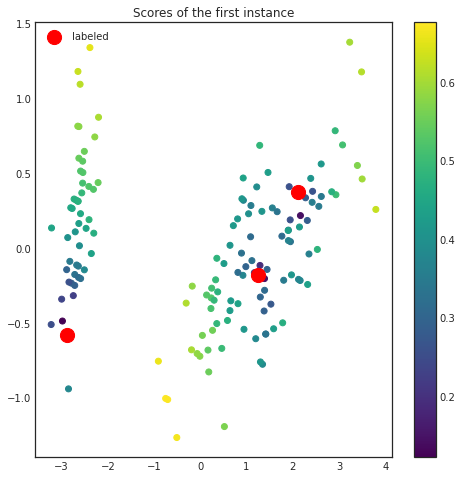

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
transformed_pool = pca.transform(X_pool)
transformed_training = pca.transform(X_training)

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(8, 8))
    plt.scatter(transformed_pool[:, 0], transformed_pool[:, 1], c=scores, cmap='viridis')
    plt.colorbar()
    plt.scatter(transformed_training[:, 0], transformed_training[:, 1], c='r', s=200, label='labeled')
    plt.title('Scores of the first instance')
    plt.legend()

After scores have been calculated, the highest scoring instance is selected and removed from the pool. **This instance is not queried yet! We're still populating the batch** The scores will be recalculated until the desired number of examples are available to send for query. In this setting, we visualize the instances to be queried in the first batch.

In [45]:
query_idx, query_instances = learner.query(X_pool, n_instances=5)

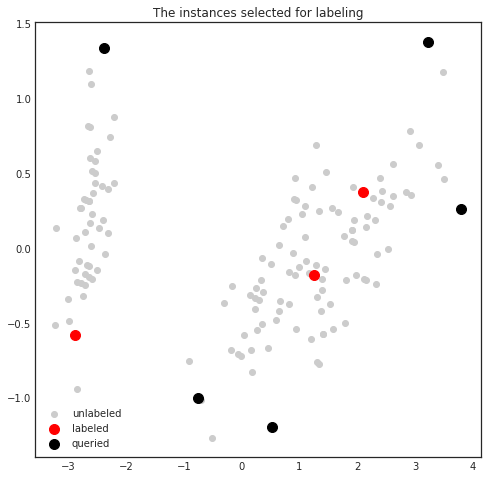

In [46]:
transformed_batch = pca.transform(query_instances)

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(8, 8))
    plt.scatter(transformed_pool[:, 0], transformed_pool[:, 1], c='0.8', label='unlabeled')
    plt.scatter(transformed_training[:, 0], transformed_training[:, 1], c='r', s=100, label='labeled')
    plt.scatter(transformed_batch[:, 0], transformed_batch[:, 1], c='k', s=100, label='queried')
    plt.title('The instances selected for labeling')
    plt.legend()

## Ranked batch-mode sampling Example

### Overview

In this example, we apply an `ActiveLearner` onto the iris dataset using **ranked batch-mode active learning**. Much like pool-based sampling, in this setting we assume a small (potentially empty) set of labeled data $\mathcal{L}$ and a large set of unlabeled data $\mathcal{U}$ such that $\left| \mathcal{L} \right| \ll \left| \mathcal{U} \right|$.

One of the drawbacks of standard pool-based sampling is their interactivity: They are best fit for cases where we have an attentive human-in-the-loop for maximizing the model's performance. Although these sampling methods _do_ support returning multiple samples per query, they tend to return redundant/sub-optimal queries if we return more than one instance from the unlabeled set. This is prohibitive in settings where we'd like to ask an active learner to return multiple (if not all) examples from the unlabeled set/pool--such as cases where we need to recruit experts for labeling and there are fixed costs to recruitment.

This implementation (see the original issue [here](https://github.com/cosmic-cortex/modAL/issues/11)) implements Cardoso et al.'s **ranked batch-mode** sampling, which not only supports batch-mode sampling (sampling methods that are built with querying multiple labels from the unlabeled set) but also establishes a _ranking_ among the batch in order for end-users to prioritize which records to label from the unlabeled set. In their own words:

> Our new approach allows the algorithm to generate an arbitrarily long query, thus making its execution less frequent. For example, a ranked query containing every available instance could be generated outside working hours. This would allow hired analysts to label instances for a full day, in parallel, if desired, without waiting for the learner update and query reconstruction.

For further reading on ranked batch-mode active learning, we highly recommend the following resources:

- Thiago N.C. Cardoso, Rodrigo M. Silva, Sérgio Canuto, Mirella M. Moro, Marcos A. Gonçalves. [Ranked batch-mode active learning](http://www.sciencedirect.com/science/article/pii/S0020025516313949). Information Sciences, Volume 379, 2017, Pages 313-337.

To enforce a reproducible result across runs, we set a random seed.

In [47]:
import numpy as np

# Set our RNG for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

### The dataset

Now we load the dataset. Yet again, we use the famous Iris dataset. For more information on the Iris dataset, see:
  - [The dataset documentation on Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set)
  - [The scikit-learn interface](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html)

In [48]:
from sklearn.datasets import load_iris

iris = load_iris()
X_raw = iris['data'] 
y_raw = iris['target']

For visualization, we apply PCA to the original dataset.

In [49]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)

This is how the dataset looks.

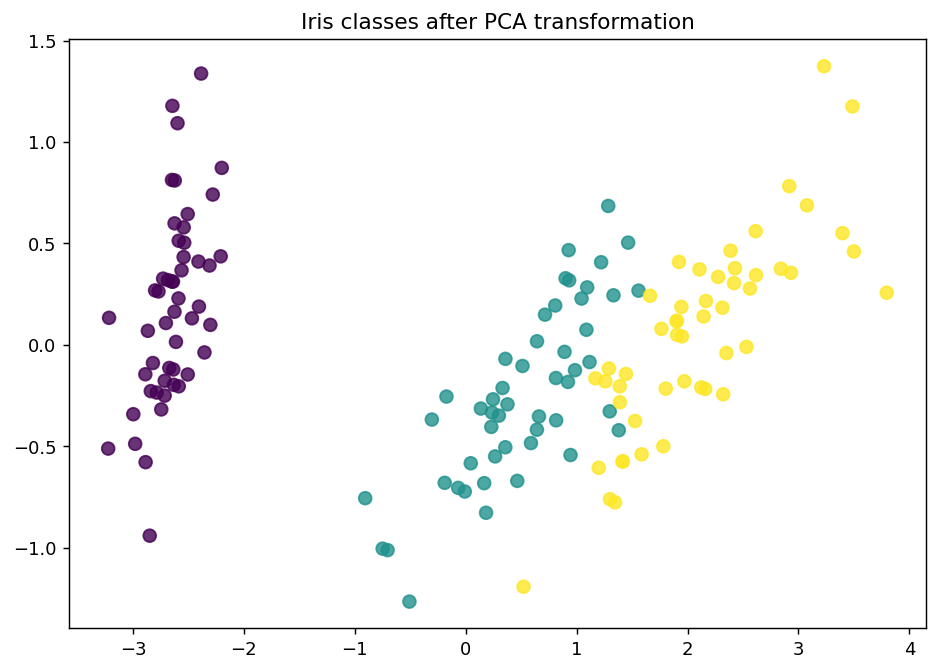

In [50]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Iris classes after PCA transformation')
plt.show()

Now we partition our `iris` dataset into a training set $\mathcal{L}$ and $\mathcal{U}$. We first specify our training set $\mathcal{L}$ consisting of 3 random examples. The remaining examples go to our "unlabeled" pool $\mathcal{U}$.

In [51]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

### Active learning with ranked batch mode sampling

For the classification, we are going to use a simple k-nearest neighbors classifier.

In [52]:
from sklearn.neural_network import MLPClassifier

# Specify our core estimator along with it's active learning model.
mlp = MLPClassifier()

Now we initialize the ```ActiveLearner```.

In [53]:
from functools import partial
from modAL.batch import uncertainty_batch_sampling
from modAL.models import ActiveLearner

# Pre-set our batch sampling to retrieve 3 samples at a time.
BATCH_SIZE = 3
preset_batch = partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)

# Specify our active learning model.
learner = ActiveLearner(
  estimator=mlp, 
  
  X_training=X_train,
  y_training=y_train, 
  
  query_strategy=preset_batch
)

Let's see how our classifier performs on the initial training set!

In [54]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

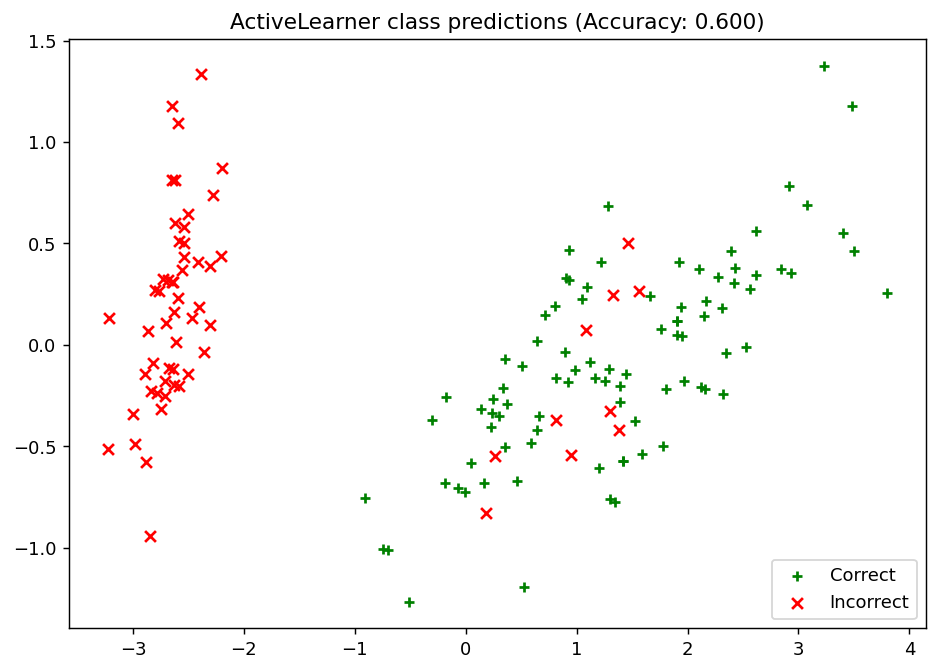

In [55]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct')
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect')
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

Now we update our model by batch-mode sampling our "unlabeled" dataset $\mathcal{U}$. We tune our classifier by allowing it to query at most 20 instances it hasn't seen before. To properly utilize batch-mode sampling, we allow our model to request three records per query (instead of 1) but subsequently only allow our model to make 6 queries. Under the hood, our classifier aims to balance uncertainty and dissimilarity in its choices to avoid redundancy.

With each requested query, we remove that record from our pool $\mathcal{U}$ and record our model's accuracy on the raw dataset.

In [56]:
# Pool-based sampling
N_RAW_SAMPLES = 20
N_QUERIES = N_RAW_SAMPLES // BATCH_SIZE

performance_history = [unqueried_score]

for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool)
    
    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool[query_index], y_pool[query_index]
    learner.teach(X=X, y=y)
    
    # Remove the queried instance from the unlabeled pool.
    X_pool = np.delete(X_pool, query_index, axis=0)
    y_pool = np.delete(y_pool, query_index)
    
    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(X_raw, y_raw)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
    
    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)

Accuracy after query 1: 0.9667
Accuracy after query 2: 0.8533
Accuracy after query 3: 0.9400
Accuracy after query 4: 0.9333
Accuracy after query 5: 0.9333
Accuracy after query 6: 0.9600


### Evaluate our model's performance

Here, we plot the query iteration index against model accuracy. As you can see, our model is able to obtain an accuracy of ~0.90 within its first query, and isn't as susceptible to getting "stuck" with querying uninformative records from our unlabeled set.
To visualize the performance of our classifier, we also plot correct and incorrect predictions on the full dataset.

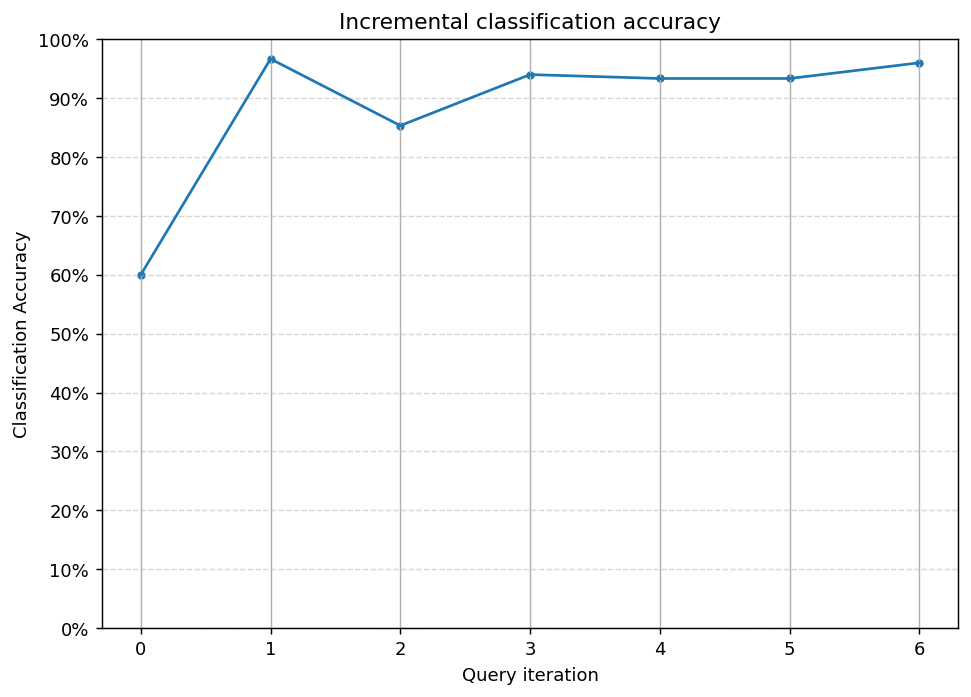

In [57]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=N_QUERIES + 3, integer=True))
ax.xaxis.grid(True)

ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0, top=1)
ax.yaxis.grid(True, linestyle='--', alpha=1/2)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

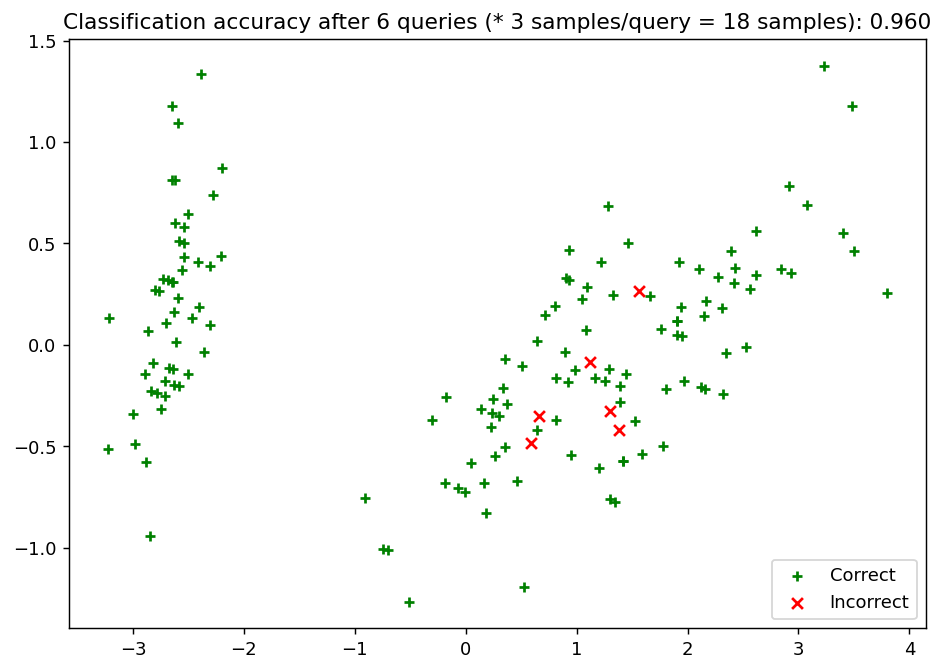

In [58]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct')
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect')

ax.set_title('Classification accuracy after {n} queries (* {batch_size} samples/query = {total} samples): {final_acc:.3f}'.format(
    n=N_QUERIES, 
    batch_size=BATCH_SIZE,
    total=N_QUERIES * BATCH_SIZE,
    final_acc=performance_history[-1]
))
ax.legend(loc='lower right')

plt.show()

## Stream-based sampling


In addition to pool-based sampling, the stream-based scenario can also be implemented easily with modAL. In this case, the labels are not queried from a pool of instances. Rather, they are given one-by-one for the learner, which queries for its label if and only if it finds the example useful. For instance, an example can be marked as useful if the prediction is uncertain, because acquiring its label would remove this uncertainty.

The executable script for this example can be [found here](https://github.com/cosmic-cortex/modAL/blob/master/examples/stream-based_sampling.py)!

To enforce a reproducible result across runs, we set a random seed.

### The dataset

In this example, we are going to learn a black square on a white background. We are going to use an MLP in a stream-based setting. First, let's generate some data!

In [59]:
import numpy as np

# creating the image
im_width = 500
im_height = 500
im = np.zeros((im_height, im_width))
im[100:im_width - 1 - 100, 100:im_height - 1 - 100] = 1

# create the data to stream from
X_full = np.transpose(
    [np.tile(np.asarray(range(im.shape[0])), im.shape[1]),
     np.repeat(np.asarray(range(im.shape[1])), im.shape[0])]
)
# map the intensity values against the grid
y_full = np.asarray([im[P[0], P[1]] for P in X_full])

# create the data to stream from
X_full = np.transpose(
    [np.tile(np.asarray(range(im.shape[0])), im.shape[1]),
     np.repeat(np.asarray(range(im.shape[1])), im.shape[0])]
)
# map the intensity values against the grid
y_full = np.asarray([im[P[0], P[1]] for P in X_full])

In case you are wondering, here is how this looks! 

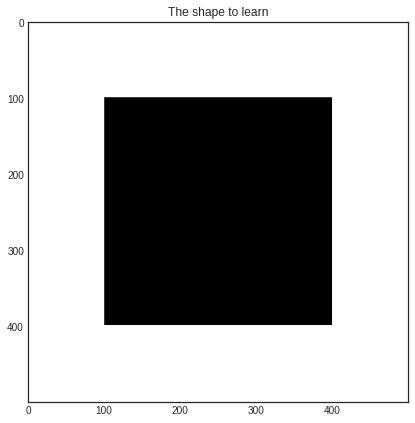

In [60]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    plt.imshow(im)
    plt.title('The shape to learn')
    plt.show()

### Active learning with stream-based sampling

For classification, we will use a stream-based classifier. Initializing the learner is the same as always.

In [61]:
from sklearn.neural_network import MLPClassifier
from modAL.models import ActiveLearner

# Specify our core estimator along with it's active learning model.
mlp = MLPClassifier()

# assembling initial training set
n_initial = 5
initial_idx = np.random.choice(range(len(X_full)), size=n_initial, replace=False)
X_train, y_train = X_full[initial_idx], y_full[initial_idx]

# initialize the learner
learner = ActiveLearner(
    estimator=mlp,
    X_training=X_train, y_training=y_train
)
unqueried_score = learner.score(X_full, y_full)

print('Initial prediction accuracy: %f' % unqueried_score)

Initial prediction accuracy: 0.669888


Let's see how our classifier performs on the initial training set! This is how the class prediction probabilities look for each pixel.

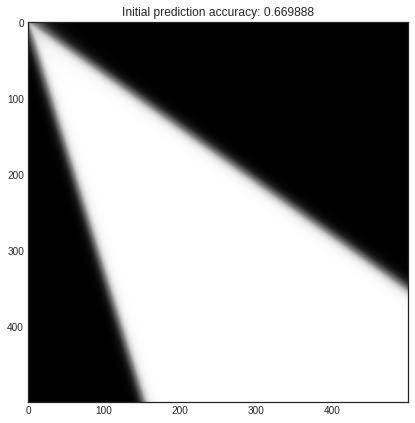

In [62]:
# visualizing initial prediciton
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    prediction = learner.predict_proba(X_full)[:, 0]
    plt.imshow(prediction.reshape(im_width, im_height))
    plt.title('Initial prediction accuracy: %f' % unqueried_score)
    plt.show()

Now we randomly sample pixels from the image. If prediction of the pixel's value is uncertain, we query the true value and teach it to the classifier. We do this until we reach at least 90% accuracy.

In [63]:
from modAL.uncertainty import classifier_uncertainty

performance_history = [unqueried_score]

# learning until the accuracy reaches a given threshold%
# mlp might take some time
while learner.score(X_full, y_full) < 0.90:
    stream_idx = np.random.choice(range(len(X_full)))
    if classifier_uncertainty(learner, X_full[stream_idx].reshape(1, -1)) >= 0.4:
        learner.teach(X_full[stream_idx].reshape(1, -1), y_full[stream_idx].reshape(-1, ))
        new_score = learner.score(X_full, y_full)
        performance_history.append(new_score)
        print('Pixel no. %d queried, new accuracy: %f' % (stream_idx, new_score))

Pixel no. 46027 queried, new accuracy: 0.692056
Pixel no. 90321 queried, new accuracy: 0.688996
Pixel no. 205152 queried, new accuracy: 0.648808


KeyboardInterrupt: ignored

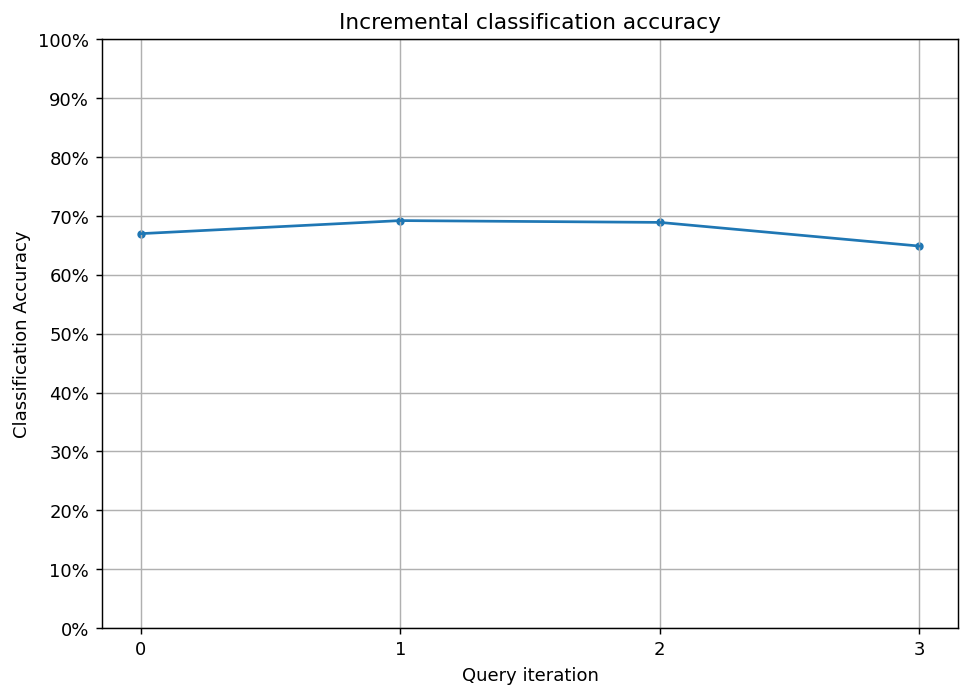

In [64]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

## Active regression
In this example, we are going to demonstrate how can the ActiveLearner be used for active regression. Here we will use Gaussian processes, because out of all possible probability distributions with the same variance, the Gaussian distribution encodes the maximum uncertainty over the real numbers. Following this, Gaussian processes provide a natural way to quantify uncertainty of prediction as the covariance function of the process. Where are the neural networks? Increasingly deep neural networks are being used to replace Gaussian processes as the "surrogate model" of the phenomenon we are seeking to understand, as suggested [here](https://www.nature.com/articles/s41524-020-00431-2) and [here](https://www.cell.com/trends/chemistry/fulltext/S2589-5974(20)30311-7). 

Moreover, rom [Deep Neural Networks as Gaussian Processes](https://arxiv.org/abs/1711.00165) - *"It has long been known that a single-layer fully-connected neural network with an i.i.d. prior over its parameters is equivalent to a Gaussian process (GP), in the limit of infinite network width. This correspondence enables exact Bayesian inference for infinite width neural networks on regression tasks by means of evaluating the corresponding GP."*

[Gaussian Processes for Keras](https://github.com/alshedivat/keras-gp) allows you to do this yourself using neural networks. Google has also released a package, [*neural-tangents*](https://github.com/google/neural-tangents).

We also recommend checking out this [informative article](https://distill.pub/2019/visual-exploration-gaussian-processes/) for how GPs can be used in a ML setting.

[Neural Network Gaussian Process wiki](https://en.wikipedia.org/wiki/Neural_network_Gaussian_process).

In our example in this notebook, we will be using the scikit-learn Gaussian Process Regressor which is *not* a neural network.

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from modAL.models import ActiveLearner

%matplotlib inline

### The dataset
For this example, we will try to learn the *noisy sine* function:

In [66]:
X = np.random.choice(np.linspace(0, 20, 10000), size=200, replace=False).reshape(-1, 1)
y = np.sin(X) + np.random.normal(scale=0.3, size=X.shape)

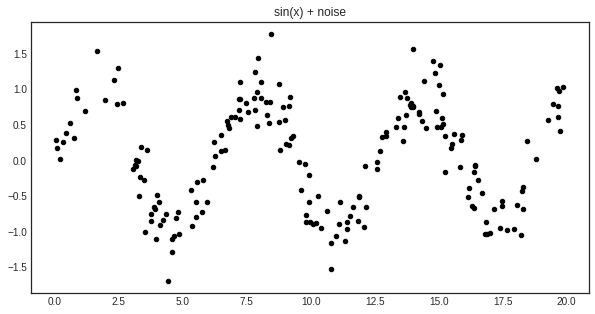

In [67]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.scatter(X, y, c='k', s=20)
    plt.title('sin(x) + noise')
    plt.show()

### Uncertainty measure and query strategy for Gaussian processes

For active learning, we shall define a custom query strategy tailored to Gaussian processes. More information on how to write your custom query strategies can be found at the page [Extending modAL](https://cosmic-cortex.github.io/modAL/Extending-modAL). In a nutshell, a *query stategy* in modAL is a function taking (at least) two arguments (an estimator object and a pool of examples), outputting the index of the queried instance. In our case, the arguments are ```regressor``` and ```X```.

In [68]:
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    return np.argmax(std)

### Active learning

Initializing the active learner is as simple as always.

In [69]:
n_initial = 5
initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=False)
X_training, y_training = X[initial_idx], y[initial_idx]

kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_training.reshape(-1, 1), y_training=y_training.reshape(-1, 1)
)

The initial regressor is not very accurate.

In [70]:
X_grid = np.linspace(0, 20, 1000)
y_pred, y_std = regressor.predict(X_grid.reshape(-1, 1), return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()

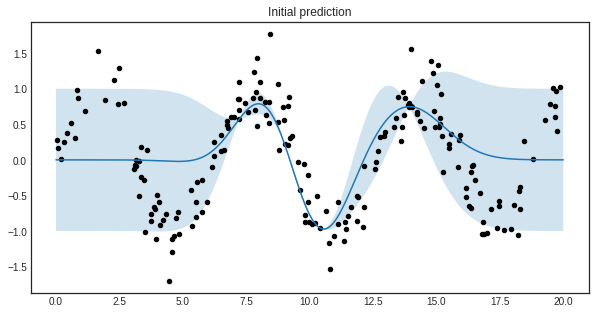

In [71]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.plot(X_grid, y_pred)
    plt.fill_between(X_grid, y_pred - y_std, y_pred + y_std, alpha=0.2)
    plt.scatter(X, y, c='k', s=20)
    plt.title('Initial prediction')
    plt.show()

The blue band enveloping the regressor represents the standard deviation of the Gaussian process at the given point. We can see immediatly that the model has high uncertainty in some places (e.g., 5 and 14), and low uncertainty in others (e.g., 2, 8.5 and 12). Now we are ready to do active learning!

In [72]:
n_queries = 10
for idx in range(n_queries):
    query_idx, query_instance = regressor.query(X)
    regressor.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))

In [73]:
y_pred_final, y_std_final = regressor.predict(X_grid.reshape(-1, 1), return_std=True)
y_pred_final, y_std_final = y_pred_final.ravel(), y_std_final.ravel()

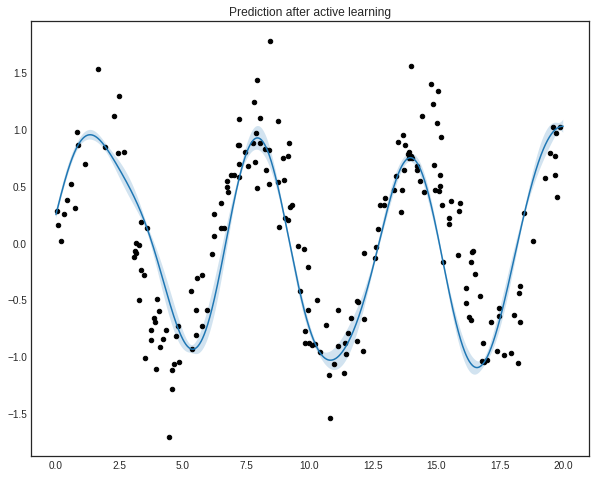

In [74]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 8))
    plt.plot(X_grid, y_pred_final)
    plt.fill_between(X_grid, y_pred_final - y_std_final, y_pred_final + y_std_final, alpha=0.2)
    plt.scatter(X, y, c='k', s=20)
    plt.title('Prediction after active learning')
    plt.show()

## Disagreement Sampling

When you have several hypotheses about your data, selecting the next instances to label can be done by measuring the disagreement between hypotheses. Naturally, there are many ways to assess that. In modAL, there are three built-in disagreement measures and query strategies: vote entropy, consensus entropy and maximum disagreement. In this [quick tutorial](https://modal-python.readthedocs.io/en/latest/content/query_strategies/Disagreement-sampling.html), we are going to review them.

In [75]:
# review that tutorial!

## Ensemble regression
With an ensemble of regressors, the standard deviation of the predictions at a given point can be thought of as a measure of disagreement. This can be used for active regression. In the following example, we are going to see how can it be done using the CommitteeRegressor class.

The executable script for this example can be [found here!](https://github.com/cosmic-cortex/modAL/blob/master/examples/ensemble_regression.py)

### The dataset
For this example, we are going to learn the *noisy absolute value* function.

In [76]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.disagreement import max_std_sampling

In [77]:
# generating the data
X = np.concatenate((np.random.rand(100)-1, np.random.rand(100)))
y = np.abs(X) + np.random.normal(scale=0.2, size=X.shape)

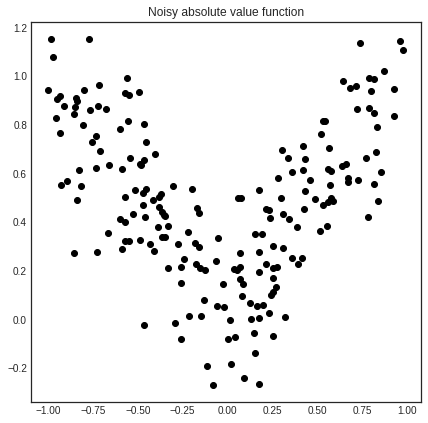

In [78]:
# visualizing the data
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    plt.scatter(X, y, c='k')
    plt.title('Noisy absolute value function')
    plt.show()

### Measuring disagreement with CommitteeRegression
If you have several regressors, measuring disagreement can be done by calculating the standard deviation of the predictions for each point. This of course cannot be achieved with classifier algorithms, where averaging class labels doesn't make sense (or it is undefined if the class labels are strings.) In the simplest setting, this is implemented in the function ```modAL.disagreement.max_std_sampling```.

This measure is default for CommitteeRegressors, so we don't need to specify this upon initialization.

### Active regression
With an ensemble of regressors, it can occur that each explains part of your data particularly well, while doing poorly on the rest. In our case, it can happen when one of them has only seen negative numbers and the other has only seen positive ones.

In [79]:
# initializing the regressors
n_initial = 10
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

initial_idx = list()
initial_idx.append(np.random.choice(range(100), size=n_initial, replace=False))
initial_idx.append(np.random.choice(range(100, 200), size=n_initial, replace=False))
learner_list = [ActiveLearner(
                        estimator=GaussianProcessRegressor(kernel),
                        X_training=X[idx].reshape(-1, 1), y_training=y[idx].reshape(-1, 1)
                )
                for idx in initial_idx]

In [80]:
# initializing the Committee
committee = CommitteeRegressor(
    learner_list=learner_list,
    query_strategy=max_std_sampling
)

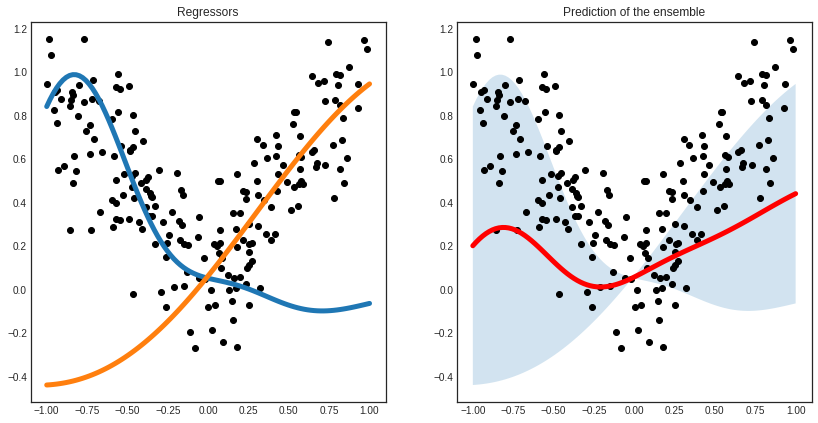

In [81]:
# visualizing the regressors
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(14, 7))
    x = np.linspace(-1, 1, 100)

    plt.subplot(1, 2, 1)
    for learner_idx, learner in enumerate(committee):
        plt.plot(x, learner.predict(x.reshape(-1, 1)), linewidth=5)
    plt.scatter(X, y, c='k')
    plt.title('Regressors')

    plt.subplot(1, 2, 2)
    pred, std = committee.predict(x.reshape(-1, 1), return_std=True)
    pred = pred.reshape(-1, )
    std = std.reshape(-1, )
    plt.plot(x, pred, c='r', linewidth=5)
    plt.fill_between(x, pred - std, pred + std, alpha=0.2)
    plt.scatter(X, y, c='k')
    plt.title('Prediction of the ensemble')
    plt.show()

After a few queries, the differences are smoothed out and the regressors reach agreement.

In [82]:
# active regression
n_queries = 10
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X.reshape(-1, 1))
    committee.teach(X[query_idx].reshape(-1, 1), y[query_idx].reshape(-1, 1))

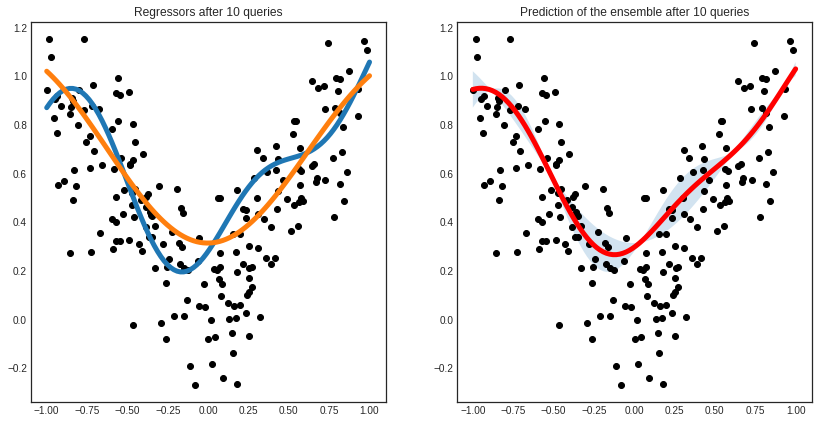

In [83]:
# visualizing the regressors
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(14, 7))
    x = np.linspace(-1, 1, 100)

    plt.subplot(1, 2, 1)
    for learner_idx, learner in enumerate(committee):
        plt.plot(x, learner.predict(x.reshape(-1, 1)), linewidth=5)
    plt.scatter(X, y, c='k')
    plt.title('Regressors after %d queries' % n_queries)

    plt.subplot(1, 2, 2)
    pred, std = committee.predict(x.reshape(-1, 1), return_std=True)
    pred = pred.reshape(-1, )
    std = std.reshape(-1, )
    plt.plot(x, pred, c='r', linewidth=5)
    plt.fill_between(x, pred - std, pred + std, alpha=0.2)
    plt.scatter(X, y, c='k')
    plt.title('Prediction of the ensemble after %d queries' % n_queries)
    plt.show()

## Bayesian optimization

When a function is expensive to evaluate, or when gradients are not available, optimizing it requires more sophisticated methods than gradient descent. One such method is Bayesian optimization, which lies close to active learning. In Bayesian optimization, instead of picking queries by maximizing the uncertainty of predictions, function values are evaluated at points where the promise of finding a better value is large. Bayesian optimization does not seek to understand the entire distribution like active learning, but to find the best value! In modAL, these algorithms are implemented with the ```BayesianOptimizer``` class, which is a sibling of ```ActiveLearner```. In the following example, we demonstrate their use on a toy problem.

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from modAL.models import BayesianOptimizer
from modAL.acquisition import optimizer_EI, max_EI

%matplotlib inline

### The function to be optimized

We are going to optimize a simple function to demonstrate the use of ```BayesianOptimizer```.

In [85]:
import numpy as np

# generating the data
X = np.linspace(0, 20, 1000).reshape(-1, 1)
y = np.sin(X)/2 - ((10 - X)**2)/50 + 2

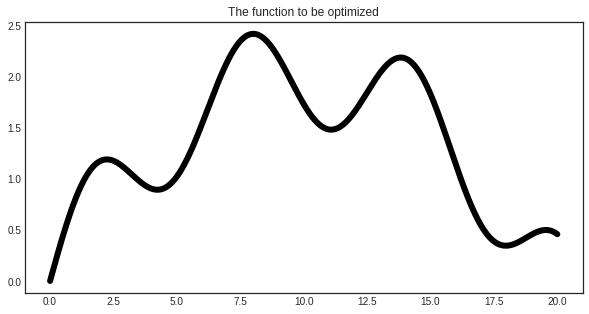

In [86]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.plot(X, y, c='k', linewidth=6)
    plt.title('The function to be optimized')
    plt.show()

### Gaussian processes
In Bayesian optimization, usually a Gaussian process regressor is used to predict the function to be optimized, but these are increasingly being replaced by deep neural networks (e.g., ["Active Learning of Deep Surrogates for PDEs"](https://www.nature.com/articles/s41524-020-00431-2)). One reason is that Gaussian processes can estimate the uncertainty of the prediction at a given point. This in turn can be used to estimate the possible gains at the unknown points.

In [87]:
# assembling initial training set
X_initial, y_initial = X[150].reshape(1, -1), y[150].reshape(1, -1)

# defining the kernel for the Gaussian process
kernel = Matern(length_scale=1.0)
regressor = GaussianProcessRegressor(kernel=kernel)

### Optimizing using *expected improvement*
During optimization, the utility of each point is given by the so-called *acquisition function*. In this case, we are going to use the *expected improvement*, which is defined by

$$EI(x) = (\mu(x) - f(x^+)) \psi\Big( \frac{\mu(x) - f(x^+)}{\sigma(x)} \Big) + \sigma(x) \phi\Big( \frac{\mu(x) - f(x^+)}{\sigma(x)} \Big),$$

where $\mu(x)$ and $\sigma(x)$ are the mean and variance of the Gaussian process regressor at $x$, $f$ is the function to be optimized with estimated maximum at $x^+$, and $\psi(z)$, $\phi(z)$ denotes the cumulative distribution function and density function of a standard Gaussian distribution. After each query, the acquisition function is reevaluated and the new query is chosen to maximize the acquisition function. 

In [88]:
# initializing the optimizer
optimizer = BayesianOptimizer(
    estimator=regressor,
    X_training=X_initial, y_training=y_initial,
    query_strategy=max_EI
)

In [89]:
# Bayesian optimization
for n_query in range(5):
    query_idx, query_inst = optimizer.query(X)
    optimizer.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))

Using *expected improvement*, the first five queries are the following.

In [90]:
y_pred, y_std = optimizer.predict(X, return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()
X_max, y_max = optimizer.get_max()

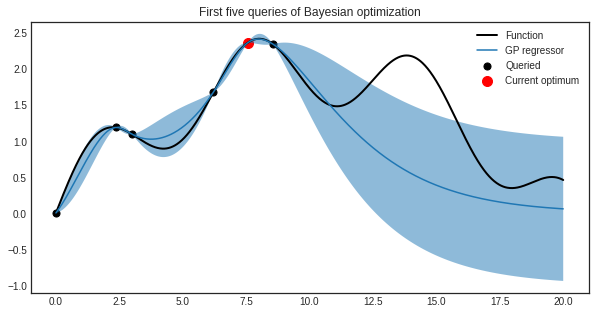

In [91]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.scatter(optimizer.X_training, optimizer.y_training, c='k', s=50, label='Queried')
    plt.scatter(X_max, y_max, s=100, c='r', label='Current optimum')
    plt.plot(X.ravel(), y, c='k', linewidth=2, label='Function')
    plt.plot(X.ravel(), y_pred, label='GP regressor')
    plt.fill_between(X.ravel(), y_pred - y_std, y_pred + y_std, alpha=0.5)
    plt.title('First five queries of Bayesian optimization')
    plt.legend()
    plt.show()

### Acquisition functions
Currently, there are three built-in acquisition functions in the ```modAL.acquisition``` module: *expected improvement*, *probability of improvement* and *upper confidence bounds*. [You can find them in detail here](https://modal-python.readthedocs.io/en/latest/content/query_strategies/Acquisition-functions.html).


## Query by committee

*Query by committee* is another popular active learning strategy, which alleviates many disadvantages of uncertainty sampling. For instance, uncertainty sampling tends to be biased towards the actual learner and it may miss important examples which are not in sight of the estimator. This is fixed by keeping several hypotheses at the same time, selecting queries where disagreement occurs between them. In this example, we shall see how this works in the simplest case, using the Iris dataset.

The executable script for this example is [available here](https://github.com/cosmic-cortex/modAL/blob/master/examples/query_by_committee.py)!

To enforce a reproducible result across runs, we set a random seed.

In [92]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 1
np.random.seed(RANDOM_STATE_SEED)

### The dataset

We are going to use the Iris dataset for this example. For more information on the Iris dataset, see [its wikipedia page](https://en.wikipedia.org/wiki/Iris_flower_data_set). For its scikit-learn interface, see [the scikit-learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html).

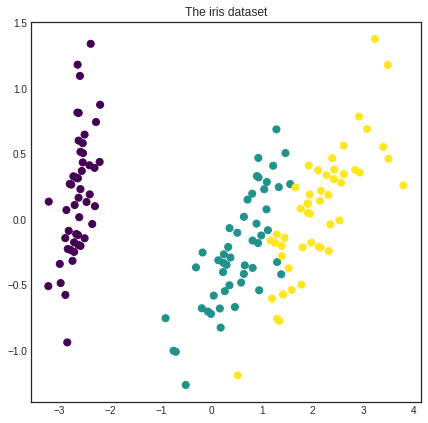

In [93]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

# loading the iris dataset
iris = load_iris()

# visualizing the classes
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    pca = PCA(n_components=2).fit_transform(iris['data'])
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=iris['target'], cmap='viridis', s=50)
    plt.title('The iris dataset')
    plt.show()


### Initializing the Committee

In this example, we are going to use the ``Committee`` class from ``modAL.models``. Its interface is almost exactly identical to the
``ActiveLearner``. Upon initialization, ``Committee`` requires a list of active learners. First, we generate the pool of unlabeled data.

In [94]:
from copy import deepcopy

# generate the pool
X_pool = deepcopy(iris['data'])
y_pool = deepcopy(iris['target'])

Now we are ready to initialize the ```Committee```. For this, we need a list of ```ActiveLearner``` objects, which we will define now.

In [95]:
import numpy as np
from sklearn.neural_network import MLPClassifier

# Specify our core estimator along with it's active learning model.
mlp = MLPClassifier()
from modAL.models import ActiveLearner, Committee

# initializing Committee members
n_members = 2
learner_list = list()

for member_idx in range(n_members):
    # initial training data
    n_initial = 2
    train_idx = np.random.choice(range(X_pool.shape[0]), size=n_initial, replace=False)
    X_train = X_pool[train_idx]
    y_train = y_pool[train_idx]

    # creating a reduced copy of the data with the known instances removed
    X_pool = np.delete(X_pool, train_idx, axis=0)
    y_pool = np.delete(y_pool, train_idx)

    # initializing learner
    learner = ActiveLearner(
        estimator=mlp,
        X_training=X_train, y_training=y_train
    )
    learner_list.append(learner)

# assembling the committee
committee = Committee(learner_list=learner_list)

As you can see, the various hypotheses (which are taking the form of ActiveLearners) can be quite different.

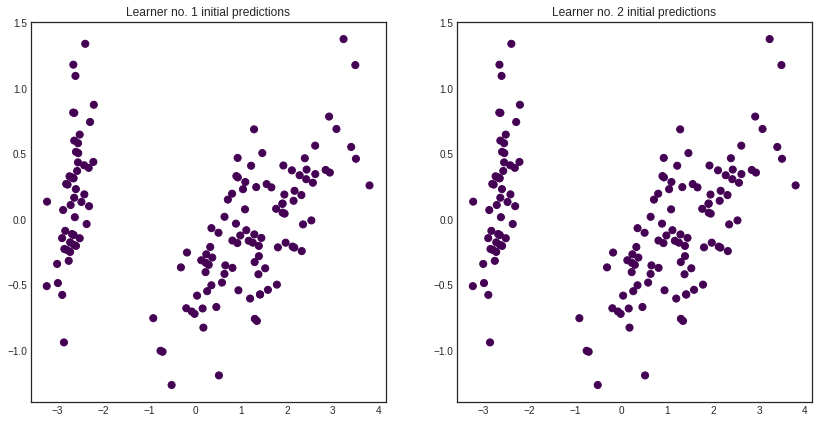

In [96]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(n_members*7, 7))
    for learner_idx, learner in enumerate(committee):
        plt.subplot(1, n_members, learner_idx + 1)
        plt.scatter(x=pca[:, 0], y=pca[:, 1], c=learner.predict(iris['data']), cmap='viridis', s=50)
        plt.title('Learner no. %d initial predictions' % (learner_idx + 1))
    plt.show()

Prediction is done by averaging the class probabilities for each learner and chosing the most likely class.

### Active learning

The active learning loop is the same as for the ``ActiveLearner``.

In [97]:
performance_history = [unqueried_score]

# query by committee
n_queries = 20
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool)
    committee.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    performance_history.append(committee.score(iris['data'], iris['target']))
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)

After a few queries, the hypotheses straighten out their disagreements and reach consensus. Prediction accuracy is greatly improved in this case.

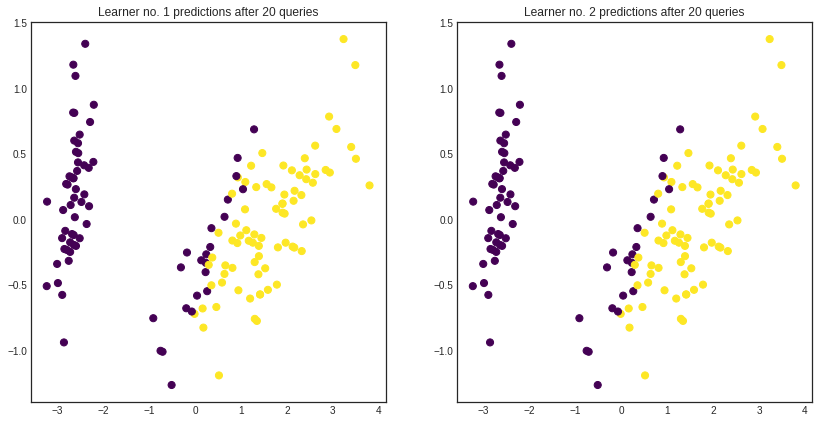

In [98]:
# visualizing the final predictions per learner
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(n_members*7, 7))
    for learner_idx, learner in enumerate(committee):
        plt.subplot(1, n_members, learner_idx + 1)
        plt.scatter(x=pca[:, 0], y=pca[:, 1], c=learner.predict(iris['data']), cmap='viridis', s=50)
        plt.title('Learner no. %d predictions after %d queries' % (learner_idx + 1, n_queries))
    plt.show()

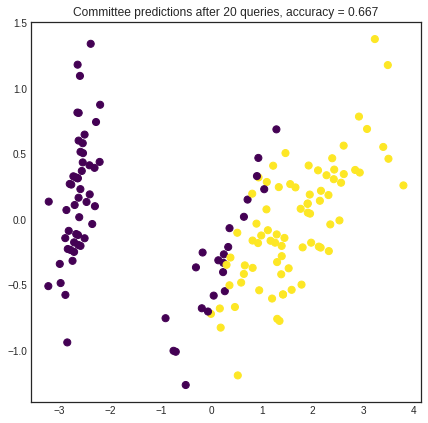

In [99]:
# visualizing the Committee's predictions
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    prediction = committee.predict(iris['data'])
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=prediction, cmap='viridis', s=50)
    plt.title('Committee predictions after %d queries, accuracy = %1.3f'
              % (n_queries, committee.score(iris['data'], iris['target'])))
    plt.show()

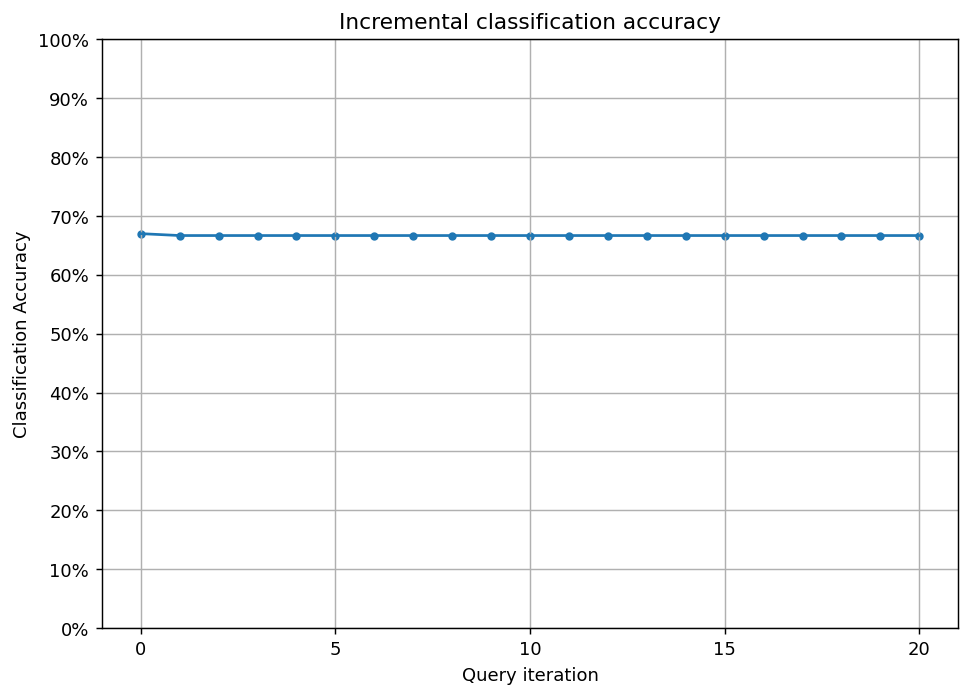

In [100]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

## Bootstrapping and bagging


Bootstrapping and bagging can be very useful when using ensemble models such as the Committee. In essence, bootstrapping is random sampling with replacement from the available training data. Bagging (= bootstrap aggregation) involves bootstrapping many times and training an estimator for each bootstrapped dataset. Bagging is available in modAL for both the base ActiveLearner model and the Committee model. In this short tutorial, we are going to see how to perform bootstrapping and bagging in your active learning workflow.

The executable script for this example can be [found here](https://github.com/cosmic-cortex/modAL/blob/master/examples/bagging.py)!

To enforce a reproducible result across runs, we set a random seed.

In [101]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

### The dataset

In this short example, we will try to learn the shape of three black disks on a white background.

In [102]:
import numpy as np
from itertools import product

# creating the dataset
im_width = 500
im_height = 500
data = np.zeros((im_height, im_width))
# each disk is coded as a triple (x, y, r), where x and y are the centers and r is the radius
disks = [(150, 150, 80), (200, 380, 50), (360, 200, 100)]
for i, j in product(range(im_width), range(im_height)):
    for x, y, r in disks:
        if (x-i)**2 + (y-j)**2 < r**2:
            data[i, j] = 1

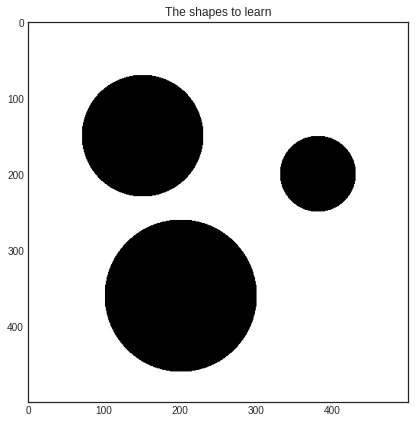

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline

# visualizing the dataset
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    plt.imshow(data)
    plt.title('The shapes to learn')
    plt.show()

### Initializing the learners with bootstrapping

First we will train three ActiveLearners on a bootstrapped dataset. Then we will bundle them together in a Committee and see how bagging is done with modAL.

In [104]:
# create the pool from the image
X_pool = np.transpose(
    [np.tile(np.asarray(range(data.shape[0])), data.shape[1]),
     np.repeat(np.asarray(range(data.shape[1])), data.shape[0])]
)
# map the intensity values against the grid
y_pool = np.asarray([data[P[0], P[1]] for P in X_pool])

# initial training data
initial_idx = np.random.choice(range(len(X_pool)), size=500)

In [105]:
from sklearn.neural_network import MLPClassifier

# Specify our core estimator along with it's active learning model.
mlp = MLPClassifier()

from modAL.models import ActiveLearner, Committee

# initializing the learners
n_learners = 3
learner_list = []
for _ in range(n_learners):
    learner = ActiveLearner(
        estimator=mlp,
        X_training=X_pool[initial_idx], y_training=y_pool[initial_idx],
        bootstrap_init=True
    )
    learner_list.append(learner)

As you can see, the main deviation from prior use of the ActiveLearner is passing ``bootstrap_init=True`` upon initialization. This makes it train the model on a bootstrapped dataset, although it stores the *complete* training dataset among its known examples. In this case, here is how the classifiers perform:

We can put our learners together in a Committee and see how they perform.

In [106]:
# assembling the Committee
committee = Committee(learner_list)

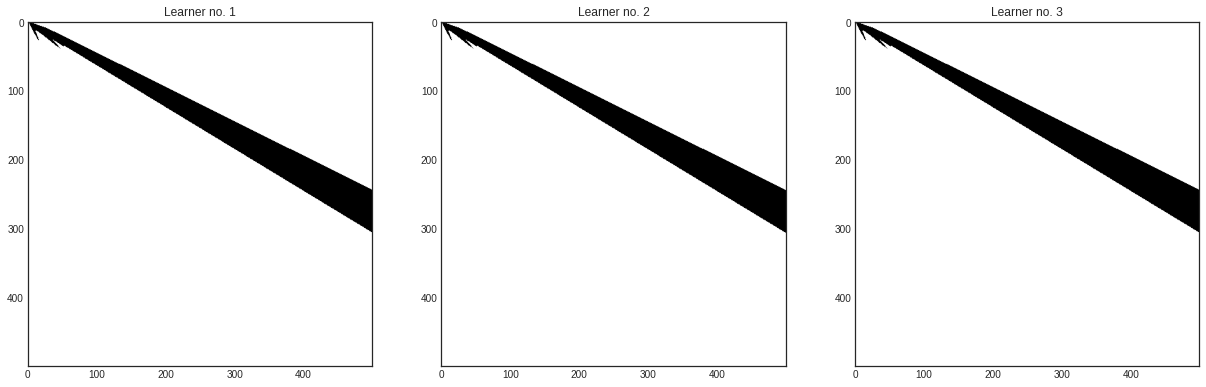

In [107]:
# visualizing every learner in the Committee
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7*n_learners, 7))
    for learner_idx, learner in enumerate(committee):
        plt.subplot(1, n_learners, learner_idx+1)
        plt.imshow(learner.predict(X_pool).reshape(im_height, im_width))
        plt.title('Learner no. %d' % (learner_idx + 1))
    plt.show()

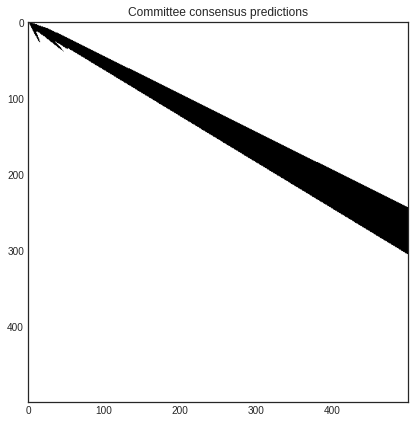

In [108]:
# visualizing the Committee's predictions
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    plt.imshow(committee.predict(X_pool).reshape(im_height, im_width))
    plt.title('Committee consensus predictions')
    plt.show()

### Bagging


If you would like to take each learner in the Committee and retrain them using bagging, you can use the ``.rebag()`` method:

In [109]:
committee.rebag()

In this case, the classifiers perform in the following way after
rebagging.

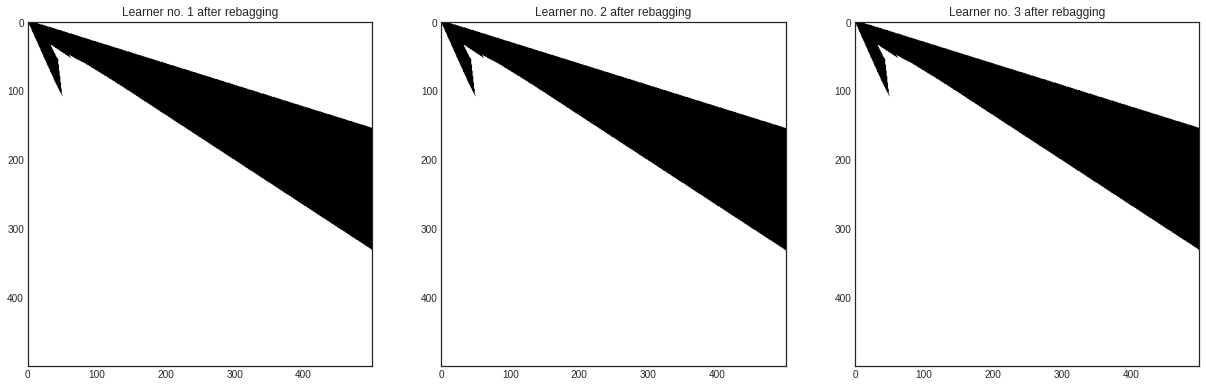

In [110]:
# visualizing the learners in the retrained Committee
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7*n_learners, 7))
    for learner_idx, learner in enumerate(committee):
        plt.subplot(1, n_learners, learner_idx+1)
        plt.imshow(learner.predict(X_pool).reshape(im_height, im_width))
        plt.title('Learner no. %d after rebagging' % (learner_idx + 1))
    plt.show()


## Keras models in modAL workflows


Thanks for the scikit-learn API of Keras, you can seamlessly integrate Keras models into your modAL workflow. In this tutorial, we will quickly introduce how to use the scikit-learn API of Keras and demonstrate active learning with it. More details on the Keras scikit-learn API [can be found here](https://keras.io/scikit-learn-api/).

The executable script for this example can be [found here](https://github.com/cosmic-cortex/modAL/blob/master/examples/keras_integration.py)!

### Keras' scikit-learn API


By default, a Keras model's interface differs from what is used for scikit-learn estimators. However, with the use of its scikit-learn wrapper, it is possible to adapt your model.

In [111]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier

# build function for the Keras' scikit-learn API
def create_keras_model():
    """
    This function compiles and returns a Keras model.
    Should be passed to KerasClassifier in the Keras scikit-learn API.
    """

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    return model

For our purposes, the ``classifier`` which we will initialize now acts just like any scikit-learn estimator.

In [112]:
# create the classifier
classifier = KerasClassifier(create_keras_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


### Active learning with Keras


In this example, we are going to use the famous MNIST dataset, which is built-in for Keras.

In [113]:
import numpy as np
from keras.datasets import mnist

# read training data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(10000, 28, 28, 1).astype('float32') / 255
y_train = keras.utils.np_utils.to_categorical(y_train, 10)
y_test = keras.utils.np_utils.to_categorical(y_test, 10)

# assemble initial data
n_initial = 1000
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)[:5000]
y_pool = np.delete(y_train, initial_idx, axis=0)[:5000]

11501568/11490434 [==============================] - 1s 0us/step


Active learning with the data and classifier ready is as easy as always. Because training is *very* expensive in large neural networks, this time we are going to query the best 200 instances each time we measure the uncertainty of the pool.

In [114]:
from modAL.models import ActiveLearner

# initialize ActiveLearner
learner = ActiveLearner(
    estimator=classifier,
    X_training=X_initial, y_training=y_initial,
    verbose=1
)

32/32 [==============================] - 10s 8ms/step - loss: 2.3144 - accuracy: 0.1030


To make sure that you train only on newly queried labels, pass ``only_new=True`` to the ``.teach()`` method of the learner.

In [115]:
# the active learning loop
n_queries = 10
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(X_pool, n_instances=100, verbose=0)
    learner.teach(
        X=X_pool[query_idx], y=y_pool[query_idx], only_new=True,
        verbose=1
    )
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)

Query no. 1
4/4 [==============================] - 0s 29ms/step - loss: 2.2676 - accuracy: 0.2300
Query no. 2
4/4 [==============================] - 0s 5ms/step - loss: 2.2999 - accuracy: 0.0700
Query no. 3
4/4 [==============================] - 0s 5ms/step - loss: 2.3381 - accuracy: 0.0400
Query no. 4
4/4 [==============================] - 0s 5ms/step - loss: 2.2782 - accuracy: 0.1400
Query no. 5
4/4 [==============================] - 0s 6ms/step - loss: 2.2953 - accuracy: 0.1100
Query no. 6
4/4 [==============================] - 1s 6ms/step - loss: 2.2460 - accuracy: 0.2200
Query no. 7
4/4 [==============================] - 1s 7ms/step - loss: 2.2735 - accuracy: 0.2100
Query no. 8
4/4 [==============================] - 0s 5ms/step - loss: 2.2913 - accuracy: 0.1500
Query no. 9
4/4 [==============================] - 0s 5ms/step - loss: 2.3176 - accuracy: 0.0900
Query no. 10
4/4 [==============================] - 0s 6ms/step - loss: 2.3104 - accuracy: 0.0500


## Diversity Sampling

Another way to sample data for training is called *diversity sampling* and its logic relates to that of information density. By selecting points far from the decision boundary and your data, you may improve generalization to completely new datasets. You can find this detailed in this [cheat-sheet](https://towardsdatascience.com/https-towardsdatascience-com-diversity-sampling-cheatsheet-32619693c304). 

Some ways to do diversity sampling are:

- Model-based Outliers: sampling for low activation in your logits and hidden layers to find items that are confusing to your model because of lack of information
- Cluster-based Sampling: using Unsupervised Machine Learning to sample data from all the meaningful trends in your data’s feature-space (similar to information density)
- Representative Sampling: sampling items most representative of the target domain for your model, relative to your current training data
- Real-World Diversity: using sampling strategies that increase fairness when trying to support real-world diversity.

**TODO**: Include examples from: https://github.com/rmunro/pytorch_active_learning/blob/master/diversity_sampling.py




## Active Transfer Learning

[Active Transfer Learning](https://medium.com/pytorch/active-transfer-learning-with-pytorch-71ed889f08c1)

[**TODO**: In future versions of this notebook, we will implement [this](https://github.com/rmunro/pytorch_active_learning/blob/master/advanced_active_learning.py), potentially using BERT or pre-trained image models as the prior models to transfer].

## GANs and Semi-Supervised Learning for Active Learning and Data Augmentation

[**TODO**: In future versions of this notebook, we will implement a classification example drawing from one of the following:

- [Generative Adversarial Active Learning
](https://arxiv.org/abs/1702.07956), [code](https://github.com/leibinghe/GAAL-based-outlier-detection)

- [Adversarial Sampling for Active Learning](https://openaccess.thecvf.com/content_WACV_2020/papers/Mayer_Adversarial_Sampling_for_Active_Learning_WACV_2020_paper.pdf)

- [Mean teachers are better role models: Weight-averaged consistency targets improve semi-supervised deep learning results](https://arxiv.org/abs/1703.01780), [code](https://github.com/CuriousAI/mean-teacher)

- [GAN Data Augmentation Through Active Learning Inspired Sample Acquisition ](https://openaccess.thecvf.com/content_CVPRW_2019/papers/Uncertainty%20and%20Robustness%20in%20Deep%20Visual%20Learning/Nielsen_GAN_Data_Augmentation_Through_Active_Learning_Inspired_Sample_Acquisition_CVPRW_2019_paper.pdf), [code](https://github.com/AntreasAntoniou/DAGAN)]

# Adaptive Learning and Bayesian Optimization

Adaptive experimentation is the machine-learning guided process of iteratively exploring a (possibly infinite) parameter space in order to identify optimal configurations in a resource-efficient manner. **This is critical for our experimentations with deep learning model parameters.** The Facebook AI [Ax](https://github.com/facebook/Ax) code currently supports Bayesian optimization and bandit optimization as exploration strategies. Bayesian optimization in Ax is powered by [BoTorch](https://github.com/pytorch/botorch
), a modern library for Bayesian optimization research built on PyTorch.

[Facebook AI post on Ax/BOTorch](https://ai.facebook.com/blog/open-sourcing-ax-and-botorch-new-ai-tools-for-adaptive-experimentation/).

[Eytan Backshy paper(s) on BOTorch](https://proceedings.neurips.cc/paper/2020/hash/f5b1b89d98b7286673128a5fb112cb9a-Abstract.html)

We will be drawing upon tutorials on the [Ax tutorial page](https://ax.dev/tutorials/). 

The 3 API tutorials: Loop, Service, and Developer each showcase optimization on a constrained Hartmann6 problem (a function with multiple local minima), with the Loop API being simplest to use and the Developer API being the most customizable.

The HARTMANN 6-dimensional function can be found [here](https://www.sfu.ca/~ssurjano/hart6.html), which is the optimsation problem being attempted in the first tutorial.


## Loop API Example on Hartmann6

The loop API is the most lightweight way to do optimization in Ax. The user makes one call to `optimize`, which performs all of the optimization under the hood and returns the optimized parameters.

For more customizability of the optimization procedure, consider the Service or Developer API.

In [116]:
!pip install ax-platform

     |████████████████████████████████| 950 kB 22.5 MB/s 
     |████████████████████████████████| 347 kB 63.9 MB/s 
     |████████████████████████████████| 310 kB 74.5 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=5219f7dcd87a67491031d227aabb2f8475c2e3328e21f128d131b27fa3853c31
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch


In [117]:
import numpy as np

from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.metrics.branin import branin
from ax.utils.measurement.synthetic_functions import hartmann6
from ax.utils.notebook.plotting import render, init_notebook_plotting

init_notebook_plotting()

Output hidden; open in https://colab.research.google.com to view.

### 1. Define evaluation function

First, we define an evaluation function that is able to compute all the metrics needed for this experiment. This function needs to accept a set of parameter values and can also accept a weight. It should produce a dictionary of metric names to tuples of mean and standard error for those metrics.

In [118]:
def hartmann_evaluation_function(parameterization):
    x = np.array([parameterization.get(f"x{i+1}") for i in range(6)])
    # In our case, standard error is 0, since we are computing a synthetic function.
    return {"hartmann6": (hartmann6(x), 0.0), "l2norm": (np.sqrt((x ** 2).sum()), 0.0)}

If there is only one metric in the experiment – the objective (e.g., performance or loss minimization for a DNN) – then the evaluation function can return a single tuple of mean and SEM, in which case Ax will assume that evaluation corresponds to the objective. It can also return only the mean as a float, in which case Ax will treat SEM as unknown and use a model that can infer it. For more details on evaluation function, refer to the "Trial Evaluation" section in the docs.

### 2. Run optimization
The setup for the loop is fully compatible with JSON. The optimization algorithm is selected based on the properties of the problem search space.

In [119]:
best_parameters, values, experiment, model = optimize(
    parameters=[
        {
            "name": "x1",
            "type": "range",
            "bounds": [0.0, 1.0],
            "value_type": "float",  # Optional, defaults to inference from type of "bounds".
            "log_scale": False,  # Optional, defaults to False.
        },
        {
            "name": "x2",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
        {
            "name": "x3",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
        {
            "name": "x4",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
        {
            "name": "x5",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
        {
            "name": "x6",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
    ],
    experiment_name="test",
    objective_name="hartmann6",
    evaluation_function=hartmann_evaluation_function,
    minimize=True,  # Optional, defaults to False.
    parameter_constraints=["x1 + x2 <= 20"],  # Optional.
    outcome_constraints=["l2norm <= 1.25"],  # Optional.
    total_trials=30, # Optional.
)

[INFO 04-17 13:42:23] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x2. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-17 13:42:23] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x3. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-17 13:42:23] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x4. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-17 13:42:23] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x5. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-17 

And we can introspect optimization results:

In [120]:
best_parameters

{'x1': 0.1588438589823199,
 'x2': 0.15266664992467102,
 'x3': 0.3154706378297844,
 'x4': 0.301503504995152,
 'x5': 0.3209182357285231,
 'x6': 0.6688500616519296}

In [121]:
means, covariances = values
means

{'hartmann6': -3.092058224240956, 'l2norm': 0.8884348452969338}

For comparison, minimum of Hartmann6 is:

In [122]:
hartmann6.fmin

-3.32237

### 3. Plot results
Here we arbitrarily select "x1" and "x2" as the two parameters to plot for both metrics, "hartmann6" and "l2norm".

In [123]:
render(plot_contour(model=model, param_x='x1', param_y='x2', metric_name='hartmann6'))

In [124]:
render(plot_contour(model=model, param_x='x1', param_y='x2', metric_name='l2norm'))

We also plot optimization trace, which shows best hartmann6 objective value seen by each iteration of the optimization:

In [125]:
# `plot_single_method` expects a 2-d array of means, because it expects to average means from multiple 
# optimization runs, so we wrap out best objectives array in another array.
best_objectives = np.array([[trial.objective_mean for trial in experiment.trials.values()]])
best_objective_plot = optimization_trace_single_method(
    y=np.minimum.accumulate(best_objectives, axis=1),
    optimum=hartmann6.fmin,
    title="Model performance vs. # of iterations",
    ylabel="Hartmann6",
)
render(best_objective_plot)

## Service and Developer Ax Tutorials

Because they are somewhat more involved, we provide links to the service and developer API tutorials for more functionality on the Hartmann6 problem.

- [Service API Example on Hartmann6](https://colab.research.google.com/drive/1IYoRdrogZAjIy59ap_BNgd0x-4ZzSZc0?usp=sharing)
- [Developer API Example on Hartmann6](https://colab.research.google.com/drive/10IpArYt4363hKtPGN1D3rfxU0_3ARNaa?usp=sharing)

## Tune a CNN on MNIST

Now we explore DNN optimization using Ax to tune two hyperparameters (learning rate and momentum) for a PyTorch CNN on the MNIST dataset trained using SGD with momentum.


In [126]:
import torch
import numpy as np

from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.utils.tutorials.cnn_utils import load_mnist, train, evaluate, CNN

init_notebook_plotting()

Output hidden; open in https://colab.research.google.com to view.

In [127]:
torch.manual_seed(12345)
dtype = torch.float
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1. Load MNIST data
First, we need to load the MNIST data and partition it into training, validation, and test sets.

Note: this will download the dataset if necessary.

In [128]:
BATCH_SIZE = 512
train_loader, valid_loader, test_loader = load_mnist(batch_size=BATCH_SIZE)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### 2. Define function to optimize
In this tutorial, we want to optimize classification accuracy on the validation set as a function of the learning rate and momentum. The function takes in a parameterization (set of parameter values), computes the classification accuracy, and returns a dictionary of metric name ('accuracy') to a tuple with mean and standard error.

In [129]:
def train_evaluate(parameterization):
    net = CNN()
    net = train(net=net, train_loader=train_loader, parameters=parameterization, dtype=dtype, device=device)
    return evaluate(
        net=net,
        data_loader=valid_loader,
        dtype=dtype,
        device=device,
    )

### 3. Run the optimization loop
Here, we set bounds on the learning rate and momentum and set the parameter space for the learning rate to be on a log scale. 

In [130]:
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        {"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},
    ],
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)

[INFO 04-17 13:44:19] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-17 13:44:19] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-17 13:44:19] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[1e-06, 0.4], log_scale=True), RangeParameter(name='momentum', parameter_type=FLOAT, range=[0.0, 1.0])], parameter_constraints=[]).
[INFO 04-17 13:44:19] ax.modelbridge.dispatch_utils: Using Bayesian optimization since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 04-17 13:44:19] ax.

We can introspect optimal parameters and their outcomes:

In [131]:
best_parameters

{'lr': 0.0003512081364612078, 'momentum': 0.8261714657803974}

In [132]:
means, covariances = values
means, covariances

({'accuracy': 0.9486872471668079},
 {'accuracy': {'accuracy': 5.2090837718854745e-05}})

### 4. Plot response surface

Contour plot showing classification accuracy as a function of the two hyperparameters.

The black squares show points that we have actually run; notice how they are clustered in the optimal region.

In [133]:
render(plot_contour(model=model, param_x='lr', param_y='momentum', metric_name='accuracy'))

### 5. Plot best objective as a function of the iteration

Show the model accuracy improving as we identify better hyperparameters.

In [134]:
# `plot_single_method` expects a 2-d array of means, because it expects to average means from multiple 
# optimization runs, so we wrap out best objectives array in another array.
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])
best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot)

### 6. Train CNN with best hyperparameters and evaluate on test set
Note that the resulting accuracy on the test set might not be exactly the same as the maximum accuracy achieved on the evaluation set throughout optimization. 

In [135]:
data = experiment.fetch_data()
df = data.df
best_arm_name = df.arm_name[df['mean'] == df['mean'].max()].values[0]
best_arm = experiment.arms_by_name[best_arm_name]
best_arm

Arm(name='5_0', parameters={'lr': 0.0003512081364612078, 'momentum': 0.8261714657803974})

In [136]:
combined_train_valid_set = torch.utils.data.ConcatDataset([
    train_loader.dataset.dataset, 
    valid_loader.dataset.dataset,
])
combined_train_valid_loader = torch.utils.data.DataLoader(
    combined_train_valid_set, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
)

In [137]:
net = train(
    net=CNN(),
    train_loader=combined_train_valid_loader, 
    parameters=best_arm.parameters,
    dtype=dtype,
    device=device,
)
test_accuracy = evaluate(
    net=net,
    data_loader=test_loader,
    dtype=dtype,
    device=device,
)

In [138]:
print(f"Classification Accuracy (test set): {round(test_accuracy*100, 2)}%")

Classification Accuracy (test set): 97.68%


## Multi-task Bayesian Optimization

This tutorial uses synthetic functions to illustrate Bayesian optimization using a multi-task Gaussian Process in Ax. A typical use case is optimizing an expensive-to-evaluate (online) system with supporting (offline) simulations of that system.

Bayesian optimization with a multi-task kernel (Multi-task Bayesian optimization) is described by Swersky et al.  (2013). Letham and Bakshy (2019) describe using multi-task Bayesian optimization to tune a ranking system with a mix of online and offline (simulator) experiments.

This tutorial produces the results of Online Appendix 2 from [that paper](https://arxiv.org/pdf/1904.01049.pdf).

The synthetic problem used here is to maximize the Hartmann 6 function described above (a classic optimization test problem in 6 dimensions). The objective is treated as unknown, which we model with separate GPs. The objective is noisy.

Throughout optimization we can make nosiy observations directly of the objective (an online observation), and we can make noisy observations of a biased version of the objective (offline observations). Bias is simulated by passing the function values through a piecewise linear function. Offline observations are much less time-consuming than online observations, so we wish to use them to improve our ability to optimize the online objective.

In [139]:
from copy import deepcopy
import numpy as np
import pandas as pd
from scipy.stats import norm
import time

from ax.core.data import Data
from ax.core.observation import ObservationFeatures, observations_from_data
from ax.core.optimization_config import OptimizationConfig
from ax.core.search_space import SearchSpace
from ax.core.objective import Objective
from ax.runners.synthetic import SyntheticRunner
from ax.modelbridge.random import RandomModelBridge
from ax.core.types import ComparisonOp
from ax.core.parameter import RangeParameter, ParameterType
from ax.core.multi_type_experiment import MultiTypeExperiment
from ax.metrics.hartmann6 import Hartmann6Metric
from ax.metrics.l2norm import L2NormMetric
from ax.modelbridge.factory import get_sobol, get_GPEI, get_MTGP
from ax.core.generator_run import GeneratorRun
from ax.plot.diagnostic import interact_batch_comparison
from ax.plot.trace import optimization_trace_all_methods
from ax.utils.notebook.plotting import init_notebook_plotting,render

init_notebook_plotting()

Output hidden; open in https://colab.research.google.com to view.

### 1. Define Metric classes
For this example, the online system is optimizing a Hartmann6 function. The Metric objects for these are directly imported above. We create analagous offline versions of this metrics which are identical but have a transform applied (a piecewise linear function). We construct Metric objects for each of them.

In [140]:
# Create metric with artificial offline bias, for the objective
# by passing the true values through a piecewise linear function.

class OfflineHartmann6Metric(Hartmann6Metric):
    def f(self, x: np.ndarray) -> float:
        raw_res = super().f(x)
        m = -0.35
        if raw_res < m:
            return (1.5* (raw_res - m)) + m
        else:
            return (6.0 * (raw_res - m)) + m

### 2. Create experiment

A MultiTypeExperiment is used for managing online and offline trials together. It is constructed in several steps:

1. <b> Create the search space</b> - This is done in the usual way.
2. <b>Specify optimization config</b> - Also done in the usual way.
3. <b>Initialize Experiment</b> - In addition to the search_space and optimization_config, specify that "online" is the default trial_type. This is the main trial type for which we're optimizing. Optimization metrics are defined to be for this type and new trials assume this trial type by default.
4. <b>Establish offline trial_type</b> - Register the "offline" trial type and specify how to deploy trials of this type.
5. <b>Add offline metrics</b> - Create the offline metrics and add them to the experiment. When adding the metrics, we need to specify the trial type ("offline") and online metric name it is associated with so the model can link them.

Finally, because this is a synthetic benchmark problem where the true function values are known, we will also register metrics with the true (noiseless) function values for plotting below.

In [141]:
def get_experiment(include_true_metric=True):
    noise_sd = 0.1  # Observations will have this much Normal noise added to them
    
    # 1. Create simple search space for [0,1]^d, d=6
    param_names = [f"x{i}" for i in range(6)]
    parameters=[
        RangeParameter(
            name=param_names[i], parameter_type=ParameterType.FLOAT, lower=0.0, upper=1.0
        )
        for i in range(6)
    ]
    search_space=SearchSpace(parameters=parameters)
    
    # 2. Specify optimization config
    online_objective = Hartmann6Metric("objective", param_names=param_names, noise_sd=noise_sd)
    opt_config = OptimizationConfig(objective=Objective(online_objective, minimize=True))
    
    # 3. Init experiment
    exp = MultiTypeExperiment(
        name="mt_exp",
        search_space=search_space,
        default_trial_type="online",
        default_runner=SyntheticRunner(),
        optimization_config=opt_config,
    )
    
    # 4. Establish offline trial_type, and how those trials are deployed
    exp.add_trial_type("offline", SyntheticRunner())
    
    # 5. Add offline metrics that provide biased estimates of the online metrics
    offline_objective = OfflineHartmann6Metric("offline_objective", param_names=param_names, noise_sd=noise_sd)
    # Associate each offline metric with corresponding online metric
    exp.add_tracking_metric(metric=offline_objective, trial_type="offline", canonical_name="objective")
    
    return exp

### 3. Vizualize the simulator bias

These figures compare the online measurements to the offline measurements on a random set of points, for the objective metric. You can see the offline measurements are biased but highly correlated. This produces Fig. S3 from the paper.

In [142]:
# Generate 50 points from a Sobol sequence
exp = get_experiment(include_true_metric=False)
s = get_sobol(exp.search_space, scramble=False)
gr = s.gen(50)
# Deploy them both online and offline
exp.new_batch_trial(trial_type="online", generator_run=gr).run()
exp.new_batch_trial(trial_type="offline", generator_run=gr).run()
# Fetch data
data = exp.fetch_data()
observations = observations_from_data(exp, data)
# Plot the arms in batch 0 (online) vs. batch 1 (offline)
render(interact_batch_comparison(observations, exp, 1, 0))

### 4. The Bayesian optimization loop

Here we construct a Bayesian optimization loop that interleaves online and offline batches. The loop defined here is described in Algorithm 1 of the paper. We compare multi-task Bayesian optimization to regular Bayesian optimization using only online observations.

Here we measure performance over 3 repetitions of the loop. Each one takes 1-2 hours so the whole benchmark run will take several hours to complete.

In [143]:
# Settings for the optimization benchmark.

# This should be changed to 50 to reproduce the results from the paper.
n_reps = 3  # Number of repeated experiments, each with independent observation noise

n_init_online = 5  # Size of the quasirandom initialization run online
n_init_offline = 20  # Size of the quasirandom initialization run offline
n_opt_online = 5  # Batch size for BO selected points to be run online
n_opt_offline = 20  # Batch size for BO selected to be run offline
n_batches = 3  # Number of optimized BO batches

#### 4a. Optimization with online observations only
For the online-only case, we run `n_init_online` sobol points followed by `n_batches` batches of `n_opt_online` points selected by the GP. This is a normal Bayesian optimization loop.

In [144]:
# This function runs a Bayesian optimization loop, making online observations only.
def run_online_only_bo():
    t1 = time.time()
    ### Do BO with online only
    ## Quasi-random initialization
    exp_online = get_experiment()
    m = get_sobol(exp_online.search_space, scramble=False)
    gr = m.gen(n=n_init_online)
    exp_online.new_batch_trial(trial_type="online", generator_run=gr).run()
    ## Do BO
    for b in range(n_batches):
        print('Online-only batch', b, time.time() - t1)
        # Fit the GP
        m = get_GPEI(
            experiment=exp_online,
            data=exp_online.fetch_data(),
            search_space=exp_online.search_space,
        )
        # Generate the new batch
        gr = m.gen(
            n=n_opt_online,
            search_space=exp_online.search_space,
            optimization_config=exp_online.optimization_config,
        )
        exp_online.new_batch_trial(trial_type="online", generator_run=gr).run()

#### 4b. Multi-task Bayesian optimization
Here we incorporate offline observations to accelerate the optimization, while using the same total number of online observations as in the loop above. The strategy here is that outlined in Algorithm 1 of the paper.

1. <b> Initialization</b> - Run `n_init_online` Sobol points online, and `n_init_offline` Sobol points offline.
2. <b> Fit model </b> - Fit an MTGP to both online and offline observations.
3. <b> Generate candidates </b> - Generate `n_opt_offline` candidates using NEI.
4. <b> Launch offline batch </b> - Run the `n_opt_offline` candidates offline and observe their offline metrics.
5. <b> Update model </b> - Update the MTGP with the new offline observations.
6. <b> Select points for online batch </b> - Select the best (maximum utility) `n_opt_online` of the NEI candidates, after incorporating their offline observations, and run them online.
7. <b> Update model and repeat </b> - Update the model with the online observations, and repeat from step 3 for the next batch.

In [145]:
# Online batches are constructed by selecting the maximum utility points from the offline
# batch, after updating the model with the offline results. This function selects the max utility points according
# to the MTGP predictions.
def max_utility_from_GP(n, m, experiment, search_space, gr):
    obsf = []
    for arm in gr.arms:
        params = deepcopy(arm.parameters)
        params['trial_type'] = 'online'
        obsf.append(ObservationFeatures(parameters=params))
    # Make predictions
    f, cov = m.predict(obsf)
    # Compute expected utility
    u = -np.array(f['objective']) 
    best_arm_indx = np.flip(np.argsort(u))[:n]
    gr_new = GeneratorRun(
        arms = [
            gr.arms[i] for i in best_arm_indx
        ],
        weights = [1.] * n,
    )
    return gr_new

# This function runs a multi-task Bayesian optimization loop, as outlined in Algorithm 1 and above.
def run_mtbo():
    t1 = time.time()
    online_trials = []
    ## 1. Quasi-random initialization, online and offline
    exp_multitask = get_experiment()
    # Online points
    m = get_sobol(exp_multitask.search_space, scramble=False)
    gr = m.gen(
        n=n_init_online,
    )
    tr = exp_multitask.new_batch_trial(trial_type="online", generator_run=gr)
    tr.run()
    online_trials.append(tr.index)
    # Offline points
    m = get_sobol(exp_multitask.search_space, scramble=False)
    gr = m.gen(
        n=n_init_offline,
    )
    exp_multitask.new_batch_trial(trial_type="offline", generator_run=gr).run()
    ## Do BO
    for b in range(n_batches):
        print('Multi-task batch', b, time.time() - t1)
        # (2 / 7). Fit the MTGP
        m = get_MTGP(
            experiment=exp_multitask,
            data=exp_multitask.fetch_data(),
            search_space=exp_multitask.search_space,
        )

        # 3. Finding the best points for the online task
        gr = m.gen(
            n=n_opt_offline,
            optimization_config=exp_multitask.optimization_config,
            fixed_features=ObservationFeatures(parameters={}, trial_index=online_trials[-1]),
        )

        # 4. But launch them offline
        exp_multitask.new_batch_trial(trial_type="offline", generator_run=gr).run()
        
        # 5. Update the model
        m = get_MTGP(
            experiment=exp_multitask,
            data=exp_multitask.fetch_data(),
            search_space=exp_multitask.search_space,
        )
        
        # 6. Select max-utility points from the offline batch to generate an online batch
        gr = max_utility_from_GP(
            n=n_opt_online,
            m=m,
            experiment=exp_multitask,
            search_space=exp_multitask.search_space,
            gr=gr,
        )
        tr = exp_multitask.new_batch_trial(trial_type="online", generator_run=gr)
        tr.run()
        online_trials.append(tr.index)

#### 4c. Run both loops
Run both Bayesian optimization loops and aggregate results.

In [146]:
runners = {
    'GP, online only': run_online_only_bo,
    'MTGP': run_mtbo,
}
for rep in range(n_reps):
    print('Running rep', rep)
    for k, r in runners.items():
        r()
   

Running rep 0
Online-only batch 0 0.00536036491394043
Online-only batch 1 2.329768419265747
Online-only batch 2 11.408402442932129
Multi-task batch 0 0.009206771850585938
Multi-task batch 1 54.18430042266846
Multi-task batch 2 487.58434772491455


KeyboardInterrupt: ignored

#### References
Benjamin Letham and Eytan Bakshy. Bayesian optimization for policy search via online-offline experimentation. _arXiv preprint arXiv:1603.09326_, 2019.

Kevin Swersky, Jasper Snoek, and Ryan P Adams.  Multi-task Bayesian optimization.  In _Advances in Neural Information Processing Systems_ 26, NIPS, pages 2004–2012, 2013.

## Factorial design with empirical Bayes and Thompson Sampling

This tutorial illustrates how to run a factorial experiment. In such an experiment, each parameter (factor) can be assigned one of multiple discrete values (levels). A full-factorial experiment design explores all possible combinations of factors and levels. This is the situation we face when learning deep learning models--with many regularization hyperparameters.

But consider a formally equivalent A/B test on a website banner with a title and an image. We consider two different titles and three different images. A full-factorial experiment would compare all 2*3=6 possible combinations of title and image, to see which version of the banner performs the best. 

In this example, we first run an exploratory batch to collect data on all possible combinations. Then we use empirical Bayes to model the data and shrink noisy estimates toward the mean. Next, we use Thompson Sampling to suggest a set of arms (combinations of factors and levels) on which to collect more data. We repeat the process until we have identified the best performing combination(s). This [blog page](https://gdmarmerola.github.io/ts-for-bayesian-optim/) illustrates how this approach can solve the hyperparameter tuning problem for a DNN.

In [147]:
!pip install ax-platform==0.1.20

#After installing this, you need to restart the kernel. 

     |████████████████████████████████| 704 kB 34.6 MB/s 
     |████████████████████████████████| 395 kB 67.0 MB/s 
  Attempting uninstall: botorch
    Found existing installation: botorch 0.6.2
    Uninstalling botorch-0.6.2:
      Successfully uninstalled botorch-0.6.2
  Attempting uninstall: ax-platform
    Found existing installation: ax-platform 0.2.4
    Uninstalling ax-platform-0.2.4:
      Successfully uninstalled ax-platform-0.2.4


In [1]:
import numpy as np
import pandas as pd
import sklearn as skl
from typing import Dict, Optional, Tuple, Union
from ax import Arm, ChoiceParameter, Models, ParameterType, SearchSpace, SimpleExperiment
from ax.plot.scatter import plot_fitted
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.utils.stats.statstools import agresti_coull_sem

In [2]:
init_notebook_plotting()

Output hidden; open in https://colab.research.google.com to view.

### 1. Define the search space

First, we define our search space. A factorial search space contains a ChoiceParameter for each factor, where the values of the parameter are its levels.

In [3]:
search_space = SearchSpace(
    parameters=[
        ChoiceParameter(
            name="factor1",
            parameter_type=ParameterType.STRING,
            values=["level11", "level12", "level13"],
        ),
        ChoiceParameter(
            name="factor2",
            parameter_type=ParameterType.STRING,
            values=["level21", "level22"],
        ),
        ChoiceParameter(
            name="factor3",
            parameter_type=ParameterType.STRING,
            values=["level31", "level32", "level33", "level34"],
        ),
    ]
)

### 2. Define the evaluation function

Second, we define an evaluation function, which is responsible for computing
the mean and standard error of a given arm.

In this example, each possible parameter value is given a coefficient. The higher the level, the higher the coefficient, and the higher the coefficients, the greater the mean.

The standard error of each arm is determined by the weight passed into the evaluation function, which represents the size of the population on which this arm was evaluated. The higher the weight, the greater the sample size, and thus the lower the standard error.

In [4]:
one_hot_encoder = skl.preprocessing.OneHotEncoder(
    categories=[par.values for par in search_space.parameters.values()], 
)

def factorial_evaluation_function(
    # `parameterization` is a dict of parameter names to values of those parameters.
    parameterization: Dict[str, Optional[Union[str, bool, float]]],
    # `weight` is the weight of the parameterization, 
    # which is used to determine the variance of the estimate.
    weight: Optional[float] = None,
) -> Dict[str, Tuple[float, float]]:  # Mapping of metric names to tuple of mean and standard error.
    batch_size = 10000
    noise_level = 0.0
    weight = weight if weight is not None else 1.0
    coefficients = np.array([
        0.1, 0.2, 0.3,
        0.1, 0.2,
        0.1, 0.2, 0.3, 0.4
    ])
    features = np.array(list(parameterization.values())).reshape(1, -1)
    encoded_features = one_hot_encoder.fit_transform(features)
    z = coefficients @ encoded_features.T + np.sqrt(noise_level) * np.random.randn()
    p = np.exp(z) / (1 + np.exp(z))
    plays = np.random.binomial(batch_size, weight)
    successes = np.random.binomial(plays, p)
    mean = float(successes) / plays
    sem = agresti_coull_sem(successes, plays)
    return {
        "success_metric": (mean, sem)
    }

### 3. Define the experiment

We now set up our experiment and define the status quo arm, in which each parameter is assigned to the lowest level.

In [5]:
exp = SimpleExperiment(
    name="my_factorial_closed_loop_experiment",
    search_space=search_space,
    evaluation_function=factorial_evaluation_function,
    objective_name="success_metric",
)
exp.status_quo = Arm(
    parameters={"factor1": "level11", "factor2": "level21", "factor3": "level31"}
)

### 4. Run an exploratory batch

We then generate an a set of arms that covers the full space of the factorial design, including the status quo. There are three parameters, with two, three, and four values, respectively, so there are 24 possible arms.

In [6]:
factorial = Models.FACTORIAL(search_space=exp.search_space)
factorial_run = factorial.gen(n=-1)  # Number of arms to generate is derived from the search space.
print(len(factorial_run.arms))

24


Now we create a trial including all of these arms, so that we can collect data and evaluate the performance of each.

In [7]:
trial = (
    exp.new_batch_trial(optimize_for_power=True)
    .add_generator_run(factorial_run, multiplier=1)
)

By default, the weight of each arm in `factorial_run` will be 1. However, to optimize for power on the contrasts of `k` groups against the status quo, the status quo should be `sqrt(k)` larger than any of the treatment groups. Since we have 24 different arms in our search space, the status quo should be roughly five times larger. That larger weight is automatically set by Ax under the hood if `optimize_for_power` kwarg is set to True on new batched trial creation.

In [8]:
trial._status_quo_weight_override

4.795831523312719

### 5. Iterate using Thompson Sampling

Next, we run multiple trials (iterations of the experiment) to hone in on the optimal arm(s). 

In each iteration, we first collect data about all arms in that trial by calling `exp.eval_trial()`. Then we run Thompson Sampling, which assigns a weight to each arm that is proportional to the probability of that arm being the best. Arms whose weight exceed `min_weight` are added to the next trial, so that we can gather more data on their performance.

In [9]:
models = []
for i in range(4):
    print(f"Running trial {i+1}...")
    data = exp.eval_trial(trial)
    thompson = Models.THOMPSON(
        experiment=exp, data=data, min_weight=0.01
    )
    models.append(thompson)
    thompson_run = thompson.gen(n=-1)
    trial = exp.new_batch_trial(optimize_for_power=True).add_generator_run(thompson_run)

Running trial 1...
Running trial 2...
Running trial 3...
Running trial 4...


### Plot 1: Predicted outcomes for each arm in initial trial

The plot below shows the mean and standard error for each arm in the first trial. We can see that the standard error for the status quo is the smallest, since this arm was assigned 5x weight.

In [10]:
render(plot_fitted(models[0], metric="success_metric", rel=False))

### Plot 2: Predicted outcomes for arms in last trial

The following plot below shows the mean and standard error for each arm that made it to the last trial (as well as the status quo, which appears throughout). 

In [11]:
render(plot_fitted(models[-1], metric="success_metric", rel=False))

As expected given our evaluation function, arms with higher levels
perform better and are given higher weight. Below we see the arms
that made it to the final trial.

In [12]:
results = pd.DataFrame(
    [
        {"values": ",".join(arm.parameters.values()), "weight": weight}
        for arm, weight in trial.normalized_arm_weights().items()
    ]
)
print(results)

                    values   weight
0  level13,level22,level34  0.34205
1  level12,level22,level34  0.15795
2  level11,level21,level31  0.50000


### Plot 3: Rollout Process

We can also visualize the progression of the experience in the following rollout chart. Each bar represents a trial, and the width of the bands within a bar are proportional to the weight of the arms in that trial. 

In the first trial, all arms appear with equal weight, except for the status quo. By the last trial, we have narrowed our focus to only four arms, with arm 0_22 (the arm with the highest levels) having the greatest weight.

In [13]:
from ax.plot.bandit_rollout import plot_bandit_rollout
from ax.utils.notebook.plotting import render

render(plot_bandit_rollout(exp))

### Plot 4: Marginal Effects

Finally, we can examine which parameter values had the greatest effect on the overall arm value. As we see in the diagram below, arms whose parameters were assigned the lower level values (such as `levell1`, `levell2`, `level31` and `level32`) performed worse than average, whereas arms with higher levels performed better than average.

In [14]:
from ax.plot.marginal_effects import plot_marginal_effects
render(plot_marginal_effects(models[0], 'success_metric'))

/usr/local/lib/python3.7/dist-packages/ax/plot/marginal_effects.py:39: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



# Training Deep Models with Importance Sampling

- [Training Deep Models Faster with
Robust, Approximate Importance Sampling](https://papers.nips.cc/paper/2018/file/967990de5b3eac7b87d49a13c6834978-Paper.pdf)
- [Not All Samples Are Created Equal:
Deep Learning with Importance Sampling](http://proceedings.mlr.press/v80/katharopoulos18a/katharopoulos18a.pdf)

# Editing Neural Networks

Paper: https://arxiv.org/abs/2004.00345

Code: https://github.com/xtinkt/editable

# Knowledge Distillation

Paper: [Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531)

Code: https://keras.io/examples/vision/knowledge_distillation/


# Continual Learning - Forgetfullness in Neural Networks

(adapted from the abstract of [Overcoming catastrophic forgetting in neural networks](https://www.pnas.org/content/114/13/3521))

The ability to learn new tasks in a sequential fashion is crucial for robust artificial intelligence. Often, however, neural networks experience "catastrophic forgetting" of prior tasks when we train them on subsequent ones. Here we show that it is possible to overcome this limitation and train networks that can maintain expertise on tasks that they have not experienced for a long time.

We recommend browsing comments on this Stack Exchange post on [Catastrophic Forgetting](https://ai.stackexchange.com/questions/13289/are-neural-networks-prone-to-catastrophic-forgetting/13293).

This kind of neural network design is also called [progressive neural networks](https://arxiv.org/abs/1606.04671).



## A Gentle Introduction to Continual Learning in PyTorch

In this brief tutorial we will learn the basics of *Continual Learning* (without catastrophic forgetting) using *PyTorch*. We will use the standard MNIST benchmark so that you can swiftly run this notebook from anywhere!

This notebook is part of the **[Continual AI Colab](https://github.com/ContinualAI/colab)** is a repository meant for tutorials and demo running on Google Colaboratory. [Continual AI](https://www.continualai.org/) is an open research community on the topic of Continual Learning and AI! Join today [on slack](https://continualai.herokuapp.com/)! :-D

We will start with learning over the standard *MNIST* benchmark, then we will move in the actual continual learning setting  with the *Permuted MNIST* benchmark.




In [17]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

### MNIST: Digits recognition with PyTorch 

We begin by recognizing the ten handwritten digits learning from 60.000, 28x28 grayscale images.
For simplicity let's import a loading script we have already developed inside the **Continual AI Colab** repository:

In [18]:
!git clone https://github.com/ContinualAI/colab.git continualai/colab

Cloning into 'continualai/colab'...
remote: Enumerating objects: 373, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 373 (delta 149), reused 132 (delta 70), pack-reused 120
Receiving objects: 100% (373/373), 26.95 MiB | 17.19 MiB/s, done.
Resolving deltas: 100% (191/191), done.


In [19]:
from continualai.colab.scripts import mnist
mnist.init()

Download complete.
Save complete.


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



In [20]:
x_train, t_train, x_test, t_test = mnist.load()

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


Let's take a look at the actual images!

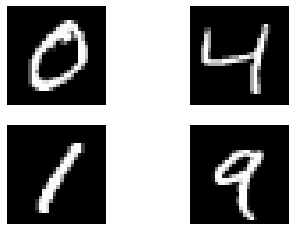

In [21]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[1, 0], cmap="gray")
axarr[0,1].imshow(x_train[2, 0], cmap="gray")
axarr[1,0].imshow(x_train[3, 0], cmap="gray")
axarr[1,1].imshow(x_train[4, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

Good! Let's now set up a few general setting before using torch...

In [22]:
# switch to False to use CPU
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

... and define our first conv-net! We will use 3 layers of convolutions and two fully connected layers:

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

Then we can write the *train* and *test* functions. Note that for simplicity here we are not using PyTorch [Data Loaders](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) but this is not recommended for efficiency.

In [24]:
def train(model, device, x_train, t_train, optimizer, epoch):
    model.train()
    
    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

Then we are ready to instantiate our model and start the training!

In [25]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [26]:
for epoch in range(1, 3):
  train(model, device, x_train, t_train, optimizer, epoch)
  test(model, device, x_test, t_test)

Train Epoch: 1 	Loss: 0.746778
Test set: Average loss: 0.0013, Accuracy: 9016/10000 (90%)

Train Epoch: 2 	Loss: 0.511482
Test set: Average loss: 0.0007, Accuracy: 9427/10000 (94%)



Wow! 94% accuracy in such a short time. 

**Questions to explore:**

*   Can you find a better parametrization to improve the final accuracy? (using some of the BO approaches detailed earlier)
*   Can you change the network architecture to improve the final accuracy?
*   Can you achieve the same performances with a smaller architecture?
*   What's the difference in accuracy if you change convolutions with fully connected layers?

Some tips here: http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354

But what if now we want we the same model to solve a new task we encounter over time like a permuted version of the same MNIST? Let's define our custom function to permute it!

In [27]:
def permute_mnist(mnist, seed):
    """ Given the training set, permute pixels of each img the same way. """

    np.random.seed(seed)
    print("starting permutation...")
    h = w = 28
    perm_inds = list(range(h*w))
    np.random.shuffle(perm_inds)
    # print(perm_inds)
    perm_mnist = []
    for set in mnist:
        num_img = set.shape[0]
        flat_set = set.reshape(num_img, w * h)
        perm_mnist.append(flat_set[:, perm_inds].reshape(num_img, 1, w, h))
    print("done.")
    return perm_mnist

In [28]:
x_train2, x_test2 = permute_mnist([x_train, x_test], 0)

starting permutation...
done.


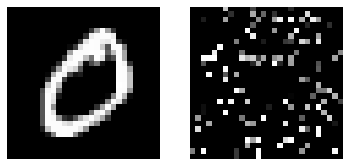

In [29]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[1, 0], cmap="gray")
axarr[1].imshow(x_train2[2, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

Amazing. Now let's see how our pre-trained model is working on both the original and the permuted MNIST dataset:

In [30]:
print("Testing on the first task:")
test(model, device, x_test, t_test)

print("Testing on the second task:")
test(model, device, x_test2, t_test);

Testing on the first task:
Test set: Average loss: 0.0007, Accuracy: 9427/10000 (94%)

Testing on the second task:
Test set: Average loss: 0.0108, Accuracy: 1032/10000 (10%)



Mmmh... that's pretty bad, our model cannot generalize to this apparently very different new task! Well, we can just finetune our model using the new permuted training set!

In [31]:
for epoch in range(1, 3):
  train(model, device, x_train2, t_train, optimizer, epoch)
  test(model, device, x_test2, t_test)

Train Epoch: 1 	Loss: 1.493245
Test set: Average loss: 0.0033, Accuracy: 7350/10000 (74%)

Train Epoch: 2 	Loss: 1.190406
Test set: Average loss: 0.0022, Accuracy: 8211/10000 (82%)



In [32]:
print("Testing on the first task:")
test(model, device, x_test, t_test)

print("Testing on the second task:")
test(model, device, x_test2, t_test);

Testing on the first task:
Test set: Average loss: 0.0200, Accuracy: 2446/10000 (24%)

Testing on the second task:
Test set: Average loss: 0.0022, Accuracy: 8211/10000 (82%)



This is annoying. Now we are not able to solve the original MNIST task anymore :-( This is the phenomenon known in literature as **Catastrophic Forgetting**! In the following section we compare three different strategies for learning continually (and trying to not forget!)

**Questions to explore:**

*   When the permuted MNIST benchmark has been firstly introduced? 
*   Can simple Dropout and Regularization techniques reduce forgetting?
*   In the permuted MNIST task, do convolutions still help increasing the accuracy?

Some tips here: https://papers.nips.cc/paper/5059-compete-to-compute

### CL Strategies

Let us now focus on some strategies to reduce catastrofic forgetting, one of the principal problems when learning continuously. in this section we will take a look at three different strategies:

1.   Naive
2.   Rehearsal
3.   Elastic Weight Consolidation (EWC)

and run them on a 3-tasks Permuted MNIST, then plot our results for comparison. For a more comprehensive overview on recent CL strategies for deep learning take a look at the recent paper "[Continuous Learning in Single-Incremental-Task Scenarios](https://arxiv.org/abs/1806.08568)".

Let's start by defining our 3 tasks with the function we introduced before:



In [33]:
# task 1
task_1 = [(x_train, t_train), (x_test, t_test)]

# task 2
x_train2, x_test2 = permute_mnist([x_train, x_test], 1)
task_2 = [(x_train2, t_train), (x_test2, t_test)]

# task 3
x_train3, x_test3 = permute_mnist([x_train, x_test], 2)
task_3 = [(x_train3, t_train), (x_test3, t_test)]

# task list
tasks = [task_1, task_2, task_3]

starting permutation...
done.
starting permutation...
done.


#### Naive Strategy

The  *Naive* strategy simply continues the back-prop process on the new batches/tasks. This is very simple, but very prone to forgetting as we witnessed before. Let's how it works on three tasks:

In [34]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [35]:
naive_accs = []

for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task: ", id)
  
  (x_train, t_train), _ = task
  
  for epoch in range(1, 2):
    train(model, device, x_train, t_train, optimizer, epoch)
    
  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc 
  
  naive_accs.append(avg_acc / 3)
  print("Avg acc: ", avg_acc / 3)
  

Training on task:  0
Train Epoch: 1 	Loss: 0.668040
Testing on task:  0
Test set: Average loss: 0.0013, Accuracy: 9015/10000 (90%)

Testing on task:  1
Test set: Average loss: 0.0113, Accuracy: 629/10000 (6%)

Testing on task:  2
Test set: Average loss: 0.0101, Accuracy: 1237/10000 (12%)

Avg acc:  36.27
Training on task:  1
Train Epoch: 1 	Loss: 1.741334
Testing on task:  0
Test set: Average loss: 0.0133, Accuracy: 1930/10000 (19%)

Testing on task:  1
Test set: Average loss: 0.0051, Accuracy: 6337/10000 (63%)

Testing on task:  2
Test set: Average loss: 0.0101, Accuracy: 1254/10000 (13%)

Avg acc:  31.736666666666668
Training on task:  2
Train Epoch: 1 	Loss: 1.632286
Testing on task:  0
Test set: Average loss: 0.0247, Accuracy: 1632/10000 (16%)

Testing on task:  1
Test set: Average loss: 0.0075, Accuracy: 3358/10000 (34%)

Testing on task:  2
Test set: Average loss: 0.0038, Accuracy: 7218/10000 (72%)

Avg acc:  40.693333333333335


**Questions to explore:**

*   Does the order of the tasks effect the final results? 

Some tips here: http://proceedings.mlr.press/v78/lomonaco17a/lomonaco17a.pdf

#### Rehearsal Strategy

Another simple CL idea is to carry on *all* or *part* of the previously encountered examples (of the previous tasks), shuffling them with the data of the current task. Using *all* past data is near optimal performance we can desire at the end of the task sequence but at the expense of much bigger memory usage.

Let's start by defining a function to shuffle our data:



In [36]:
def shuffle_in_unison(dataset, seed, in_place=False):
    """ Shuffle two (or more) list in unison. """

    np.random.seed(seed)
    rng_state = np.random.get_state()
    new_dataset = []
    for x in dataset:
        if in_place:
            np.random.shuffle(x)
        else:
            new_dataset.append(np.random.permutation(x))
        np.random.set_state(rng_state)

    if not in_place:
        return new_dataset

Now we can reset the model and optimizer and run our training over the tasks sequence:

In [37]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [38]:
rehe_accs = []
for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task: ", id)
  
  (x_train, t_train), _ = task
  
  # for previous task
  for i in range(id):
    (past_x_train, past_t_train), _ = tasks[i]
    x_train = np.concatenate((x_train, past_x_train))
    t_train = np.concatenate((t_train, past_t_train))
  
  x_train, t_train = shuffle_in_unison([x_train, t_train], 0)
  
  for epoch in range(1, 2):
    train(model, device, x_train, t_train, optimizer, epoch)
    
  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc
   
  print("Avg acc: ", avg_acc / 3)
  rehe_accs.append(avg_acc/3)

Training on task:  0
Train Epoch: 1 	Loss: 0.580441
Testing on task:  0
Test set: Average loss: 0.0014, Accuracy: 9062/10000 (91%)

Testing on task:  1
Test set: Average loss: 0.0113, Accuracy: 586/10000 (6%)

Testing on task:  2
Test set: Average loss: 0.0101, Accuracy: 1042/10000 (10%)

Avg acc:  35.63333333333333
Training on task:  1
Train Epoch: 1 	Loss: 0.837497
Testing on task:  0
Test set: Average loss: 0.0008, Accuracy: 9425/10000 (94%)

Testing on task:  1
Test set: Average loss: 0.0036, Accuracy: 7502/10000 (75%)

Testing on task:  2
Test set: Average loss: 0.0101, Accuracy: 1105/10000 (11%)

Avg acc:  60.10666666666666
Training on task:  2
Train Epoch: 1 	Loss: 0.562826
Testing on task:  0
Test set: Average loss: 0.0006, Accuracy: 9503/10000 (95%)

Testing on task:  1
Test set: Average loss: 0.0021, Accuracy: 8523/10000 (85%)

Testing on task:  2
Test set: Average loss: 0.0024, Accuracy: 8272/10000 (83%)

Avg acc:  87.66000000000001


**Questions to explore:**

*   Can you find a way to reduce the number of examples of the previous tasks to maintain in memory? 
*   Can you find a good trade-off between memory overhead and final accuracy?
*   Why is shuffling needed here?

Some tips here: https://arxiv.org/abs/1809.05922

#### Elastic Weights Consolidation (EWC) Strategy

Elastic Weights Consolidation (EWC) is a common CL strategy firstly proposed in the paper: "[Overcoming catastrophic forgetting in neural networks](https://arxiv.org/abs/1612.00796)" for deep neural networks.

It is based on the computation of the importance of each weight (fisher information) and a squared regularization loss, penalizing changes in the most important weights for the previous tasks.

It has the great advantage of **not using any** of the previous tasks data.

In [39]:
fisher_dict = {}
optpar_dict = {}
ewc_lambda = 0.4

In [40]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Now we need to define an additional function to compute the fisher information for each weight at the end of each task:

In [41]:
def on_task_update(task_id, x_mem, t_mem):

  model.train()
  optimizer.zero_grad()
  
  # accumulating gradients
  for start in range(0, len(t_mem)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_mem[start:end]), torch.from_numpy(t_mem[start:end]).long()
      x, y = x.to(device), y.to(device)
      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()

  fisher_dict[task_id] = {}
  optpar_dict[task_id] = {}

  # gradients accumulated can be used to calculate fisher
  for name, param in model.named_parameters():
    
    optpar_dict[task_id][name] = param.data.clone()
    fisher_dict[task_id][name] = param.grad.data.clone().pow(2)

We need also to modify our *train* function to add the new regularization loss:

In [42]:
def train_ewc(model, device, task_id, x_train, t_train, optimizer, epoch):
    model.train()

    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      
      ### magic here! :-)
      for task in range(task_id):
        for name, param in model.named_parameters():
          fisher = fisher_dict[task][name]
          optpar = optpar_dict[task][name]
          loss += (fisher * (optpar - param).pow(2)).sum() * ewc_lambda
      
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

Finally we can run the train over the three tasks sequence of th *Permuted MNIST*:

In [43]:
ewc_accs = []
for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task: ", id)
  
  (x_train, t_train), _ = task
  
  for epoch in range(1, 3):
    train_ewc(model, device, id, x_train, t_train, optimizer, epoch)
  on_task_update(id, x_train, t_train)
    
  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc
   
  print("Avg acc: ", avg_acc / 3)
  ewc_accs.append(avg_acc / 3)

Training on task:  0
Train Epoch: 1 	Loss: 0.827045
Train Epoch: 2 	Loss: 0.662698
Testing on task:  0
Test set: Average loss: 0.0007, Accuracy: 9461/10000 (95%)

Testing on task:  1
Test set: Average loss: 0.0116, Accuracy: 651/10000 (7%)

Testing on task:  2
Test set: Average loss: 0.0097, Accuracy: 1197/10000 (12%)

Avg acc:  37.696666666666665
Training on task:  1
Train Epoch: 1 	Loss: 1.956282
Train Epoch: 2 	Loss: 1.537789
Testing on task:  0
Test set: Average loss: 0.0066, Accuracy: 5570/10000 (56%)

Testing on task:  1
Test set: Average loss: 0.0032, Accuracy: 7846/10000 (78%)

Testing on task:  2
Test set: Average loss: 0.0115, Accuracy: 1158/10000 (12%)

Avg acc:  48.580000000000005
Training on task:  2
Train Epoch: 1 	Loss: 2.009538
Train Epoch: 2 	Loss: 1.982254
Testing on task:  0
Test set: Average loss: 0.0101, Accuracy: 5178/10000 (52%)

Testing on task:  1
Test set: Average loss: 0.0070, Accuracy: 4054/10000 (41%)

Testing on task:  2
Test set: Average loss: 0.0040, Acc

**Questions to explore:**

*   How much the `ewc_lambda` parameter effect the final results? 
*   Can you find a better parametrization to improve stability?
*   Can you find the memory overhead introduced by EWC with respect to the Naive approach?

Some tips here: https://arxiv.org/pdf/1805.06370.pdf

### Plot Results

To conclude, let's summerize our results in a nice plot! :-)

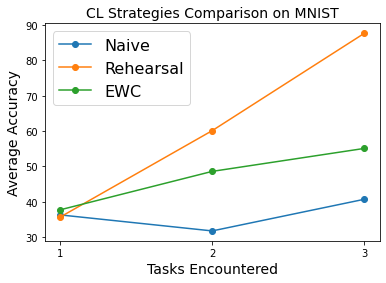

In [44]:
plt.plot([1, 2, 3], naive_accs, '-o', label="Naive")
plt.plot([1, 2, 3], rehe_accs, '-o', label="Rehearsal")
plt.plot([1, 2, 3], ewc_accs, '-o', label="EWC")
plt.xlabel('Tasks Encountered', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)
plt.title('CL Strategies Comparison on MNIST', fontsize=14);
plt.xticks([1, 2, 3])
plt.legend(prop={'size': 16});

**Questions to explore:**

*   What's the difference in terms of memory utilization among the three methods? 
*   Can you plot a similar graph highlighting the memory increase over time?

Some tips here: https://stackoverflow.com/questions/449560/how-do-i-determine-the-size-of-an-object-in-python/30316760

**Copyright (c) 2018. Continual AI. All rights reserved. **

See the accompanying LICENSE file in the GitHub repository for terms. 

*Date: 29-09-2018                                                             
Author: Vincenzo Lomonaco                                                    
E-mail: contact@continualai.org                                           
Website: continualai.org*                                               

## A simple Example of Continual Learning with Generative Replay

Generative Replay is a continual learning method that uses generative models (here GANs) to generate samples from past experiences. The idea is by learning from actual data from the present and generated data from the past we can learn without forgetting. Our generative model can create memories from which our updating model can remember its own past expertise.

In this notebook, we take on the simple seeting of MNIST disjoint - 10 tasks (digit classification 0-9).

In the setting, we have 10 task with each time one class per task. There is no overlap between tasks, and we cannot use data from past tasks. 

The goal is to train a generative model to generate all the 10 classes of mnist even if we receive data from each class one by one...using generative replay

- **At task 0 (T0) :**  We train a generator on real data (for Mnist only samples of 0) only and then we save it as G0. G0 will be used as a memory of T0.
- **At task 1 (T1) :**  We clone G0 as G1 and we train it with both real data (samples of 1) and generated data of T0 with G0. At the end of the task G1 learned to generate both 0 and 1. Then we delete G0, G1 will be use as a memory for **both** T0 and T1
- **At task 2 (T2) :** We clone G1 as G2 and ...

After 10 tasks if the generative model is efficient we are able to generate all 10 classes by this method. (Here by default we will only train on 3 tasks but you can easily modify the notebook to do all 10).

In this notebook we only train a generative model to experiment with how it works, but this method could also be use to realize an efficient memory for classification or reinforcement learning algorithms.

1. We Create the environment to execute the code, we install pytorch with cuda 8.0 for GPU acceleration.

In [45]:
!pip install wheel==0.34.1

  Attempting uninstall: wheel
    Found existing installation: wheel 0.37.1
    Uninstalling wheel-0.37.1:
      Successfully uninstalled wheel-0.37.1


In [46]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' #'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print('Platform:', platform, 'Accelerator:', accelerator)

!pip install --upgrade --force-reinstall -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

import torch
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)

Platform: cp37-cp37m Accelerator: cu80
  ERROR: HTTP error 403 while getting http://download.pytorch.org/whl/cu80/torch-0.4.0-cp37-cp37m-linux_x86_64.whl
ERROR: Could not install requirement torch==0.4.0 from http://download.pytorch.org/whl/cu80/torch-0.4.0-cp37-cp37m-linux_x86_64.whl because of HTTP error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu80/torch-0.4.0-cp37-cp37m-linux_x86_64.whl for URL http://download.pytorch.org/whl/cu80/torch-0.4.0-cp37-cp37m-linux_x86_64.whl
Torch 1.10.0+cu111 CUDA 11.1


2. We import all libraries needed for training and visualisation

In [47]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from copy import deepcopy

3. We clone the continualAI repo to bring in an easy to use data loader for mnist

In [48]:
!git clone https://github.com/ContinualAI/colab.git 

Cloning into 'colab'...
remote: Enumerating objects: 373, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 373 (delta 149), reused 132 (delta 70), pack-reused 120
Receiving objects: 100% (373/373), 26.95 MiB | 17.18 MiB/s, done.
Resolving deltas: 100% (191/191), done.


4. We import mnist and inialize it

In [49]:
!ls colab

CODE_OF_CONDUCT.md  environment.yml  LICENSE	README.md
CONTRIBUTING.md     extras	     notebooks	scripts


In [50]:
from continualai.colab.scripts import mnist
mnist.init()

Files already downloaded!


5. We can now load the data set and get training and testing data and labels

In [51]:
x_train, t_train, x_test, t_test = mnist.load()

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


6. We set a flag to use cuda for GPU acceleration and we fix the seed for reproducibility

In [52]:
# switch to False to use CPU
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

7. Creation of a generator: We will use a GAN to achieve Generative Replay.

In [53]:
class Generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self):
        super(Generator, self).__init__()

        self.latent_dim = 1024
        self.input_height = 28
        self.input_width = 28
        self.input_dim = 62
        self.output_dim = 1

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, self.latent_dim),
            nn.BatchNorm1d(self.latent_dim),
            nn.ReLU(),
            nn.Linear(self.latent_dim, 128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.BatchNorm1d(128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Sigmoid(),
        )

        self.maxPool = nn.MaxPool2d((2, 2), stride=(2, 2))
        self.Sigmoid = nn.Sigmoid()
        self.apply(self.weights_init)
    
    def reinit(self):
      self.apply(self.weights_init)

    def forward(self, input):
        input = input.view(-1, self.input_dim)
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_height // 4), (self.input_width // 4))
        x = self.deconv(x)
        return x

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

7. Here is the Discriminator for our GAN

In [54]:
class Discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self):
        super(Discriminator, self).__init__()
        self.input_height = 28
        self.input_width = 28
        self.input_dim = 1
        self.output_dim = 1

        self.latent_dim = 1024

        shape = 128 * (self.input_height // 4) * (self.input_width // 4)

        self.fc1_1 = nn.Linear(784, self.latent_dim)
        self.fc1_2 = nn.Linear(10, self.latent_dim)
        self.fc2 = nn.Linear(self.latent_dim * 2, self.latent_dim // 2)
        self.fc2_bn = nn.BatchNorm1d(self.latent_dim // 2)
        self.fc3 = nn.Linear(self.latent_dim // 2, 256)
        self.fc3_bn = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 1)

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(shape, self.latent_dim),
            nn.BatchNorm1d(self.latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(self.latent_dim, self.output_dim),
            nn.Sigmoid(),
        )
        self.aux_linear = nn.Linear(shape, 10)
        self.softmax = nn.Softmax()
        self.apply(self.weights_init)
    
    def reinit(self):
      self.apply(self.weights_init)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(x.data.shape[0], 128 * (self.input_height // 4) * (self.input_width // 4))
        return self.fc(x)

8. The function get_iter_dataset makes it possible to load data from only one particular class. It will help to load data class by class.

In [55]:
# function to get digits from only one class
def get_iter_dataset(x_train, t_train, classe=None):
    if classe is not None:
        return x_train[np.where(t_train==classe)[0]]

9. The function "run_batch" trains the Generator and Discriminator one a particular batch of data.


In [56]:
def run_batch(G, D, G_optimizer, D_optimizer, x_):
      x_ = x_.view((-1, 1, 28, 28))
    
      # y_real and y_fake are the label for fake and true data
      y_real_ = Variable(torch.ones(x_.size(0), 1))
      y_fake_ = Variable(torch.zeros(x_.size(0), 1))
      if use_cuda:
        y_real_, y_fake_ = y_real_.cuda(0), y_fake_.cuda(0)

      z_ = torch.rand((x_.size(0), z_dim))

      x_, z_ = Variable(x_), Variable(z_)

      if use_cuda:
        x_, z_ = x_.cuda(0), z_.cuda(0)

      # update D network
      D_optimizer.zero_grad()

      D_real = D(x_)
      D_real_loss = BCELoss(D_real, y_real_[:x_.size(0)])

      G_ = G(z_)
      D_fake = D(G_)
      D_fake_loss = BCELoss(D_fake, y_fake_[:x_.size(0)])

      D_loss = D_real_loss + D_fake_loss

      D_loss.backward()
      D_optimizer.step()

      # update G network
      G_optimizer.zero_grad()

      G_ = G(z_)
      D_fake = D(G_)
      G_loss = BCELoss(D_fake, y_real_[:x_.size(0)])

      G_loss.backward()
      G_optimizer.step()

In [57]:
#Declarations and Hyper-parameters

# Training hyper-parameter
nb_task = 3  # change this to 10 if you want the experiment of the full 10 classes setting
batch_size = 64
lr = 0.0002
z_dim = 62
epoch_number = 10
nb_samples = 10

G = Generator()
D = Discriminator()

# G and D are put in train mode
G.train()
D.train()

if use_cuda:
  G.cuda(0)
  D.cuda(0)

# Use of Adam optimizer 
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)
BCELoss = nn.BCELoss()

### Training Generator without Replay
In the following cell we train the generator without using Generative Replay. It show what happens when catastrophic forgetting appears. Each line of samples is ramdomly sampled from the generator at the end of each task. We can see that at the end of each task the generator is only able to generate data from the present and not from the prior task(s). 

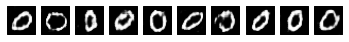

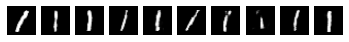

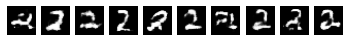

In [58]:
for task in range(nb_task):
  
  data = get_iter_dataset(x_train, t_train, classe=task)
  nb_batch = int(len(data)/batch_size)
  
  for epoch in range(epoch_number):
    for index in range(nb_batch):
      x_=torch.FloatTensor(data[index*batch_size:(index+1)*batch_size])
      run_batch(G, D, G_optimizer, D_optimizer, x_)

  
  z_ = Variable(torch.rand((nb_samples, z_dim)))
  
  if use_cuda:
    z_ = z_.cuda(0)
  samples = G(z_).data
  samples = samples.cpu().numpy()
  #plt.plot(samples[0])
  
  f, axarr = plt.subplots(1,nb_samples)
  for j in range(nb_samples):
    axarr[j].imshow(samples[j, 0], cmap="gray")
  np.vectorize(lambda ax:ax.axis('off'))(axarr);

10. This function help to generate replayed data from the GAN used as memory (Gt-1)

In [59]:
# New function to generate samples for replay
def get_replay(generator, batchsize):
  z_ = Variable(torch.rand((batchsize, z_dim)))
  if use_cuda:
    z_ = z_.cuda(0)
  return generator(z_).cpu()

###Training Generator with Replay

After seeing what happend when training without Generative Replay, we can now see the efficiency of generative replay in this setting.

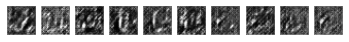

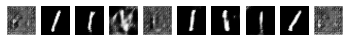

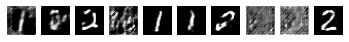

In [60]:
# We reinit D and G to not cheat
G.reinit()
D.reinit()

for task in range(nb_task):
  
  data = get_iter_dataset(x_train, t_train, classe=task)
  nb_batch = int(len(data)/batch_size)
  
  for epoch in range(epoch_number):
    for index in range(nb_batch):
      x_=torch.FloatTensor(data[index*batch_size:(index+1)*batch_size])
       
      if task > 0 :
        # We concat a batch of previously learned data
        # the more there is past task more data need to be regenerate
        replay = get_replay(G_saved, batch_size*task)
        x_=torch.cat((x_,replay),0)
      
      
      run_batch(G, D, G_optimizer, D_optimizer, x_)
      
  G_saved = deepcopy(G)
  
  z_ = Variable(torch.rand((nb_samples, z_dim)))
  
  if use_cuda:
    z_ = z_.cuda(0)
  samples = G(z_).data
  samples = samples.cpu().numpy()
  #plt.plot(samples[0])
  
  f, axarr = plt.subplots(1,nb_samples)
  for j in range(nb_samples):
    axarr[j].imshow(samples[j, 0], cmap="gray")
  np.vectorize(lambda ax:ax.axis('off'))(axarr);

### Bibliography

**Generative Models from the perspective of Continual Learning**
*Timothee Lesort, Hugo Caselles-Dupre, Michael Garcia-Ortiz,  Andrei Stoian  and David Filliat*

```
@ARTICLE{2018arXiv181209111L,
       author = {{Lesort}, Timoth{\'e}e and {Caselles-Dupr{\'e}}, Hugo and {Garcia-
        Ortiz}, Michael and {Stoian}, Andrei and {Filliat}, David},
        title = "{Generative Models from the perspective of Continual Learning}",
      journal = {arXiv e-prints},
     keywords = {Computer Science - Machine Learning, Computer Science - Artificial Intelligence, Computer Science - Computer Vision and Pattern Recognition},
         year = 2018,
        month = Dec,
          eid = {arXiv:1812.09111},
        pages = {arXiv:1812.09111},
archivePrefix = {arXiv},
       eprint = {1812.09111},
 primaryClass = {cs.LG},
       adsurl = {https://ui.adsabs.harvard.edu/\#abs/2018arXiv181209111L},
      adsnote = {Provided by the SAO/NASA Astrophysics Data System}
}
```


## Continuous Learning with Progressive Neural Networks

Another way to eleminate forgetting while keeping the benefits of transfer learning is to expand the network architecture with every task. By doing this, one can increase the capacity of the network to learn new tasks while retaining its perfromance on older ones. An example approach to achieve CL via architecture expansion is [Progressive Neural Networks(PNN)](https://https://arxiv.org/pdf/1606.04671.pdf).

**PNN**

PNN works by having part of the network (a column) dedicated to each task. Upon adding new tasks the previous columns weights get frozen so the network perfromance on those columns is fixed. To make the new columns benefit from old column knowledge through transfer learning, lateral connections `a` are added. By having a seperate lateral connection, the new column can learn from previous columns without decreasing performance on old tasks. 

The image below shows a network of 3 tasks upon adding the third task. The dashed lines are frozen weights to fix task 1 & 2 performance and `a` connections are used to link old tasks knowledge to the new task.

<img src="https://qph.fs.quoracdn.net/main-qimg-c1e7ad14cca99e0b97475ad014e02397.webp" align="center"> </img>

This network offers an architecture-based technique to solve CL. That being said, the expansion per task can be limiting when the number of tasks increases. This in addition to the fact that the network expects to have the task-id at inference time are drawbacks of this architecture. It's still intuitive and an important benchmark so we'll discuss how to make a simple PNN.


In [61]:
# some initial imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F

In [62]:
# switch to False to use CPU
use_cuda = False

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

In [63]:
# Get MNIST data
!git clone https://github.com/ContinualAI/colab.git continualai/colab

from continualai.colab.scripts import mnist
mnist.init()

fatal: destination path 'continualai/colab' already exists and is not an empty directory.
Files already downloaded!


In [64]:
# we will construct 5 tasks of MNIST, where every task is responsible for 2 digits
x_train, t_train, x_test, t_test = mnist.load()
# tasks to use
task_classes_arr = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]
tasks_num = len(task_classes_arr) # 5

task_data = []
for i, task_classes in enumerate(task_classes_arr):
  train_mask = np.isin(t_train, task_classes)
  test_mask = np.isin(t_test, task_classes)
  x_train_task, t_train_task = x_train[train_mask], t_train[train_mask]
  x_test_task, t_test_task = x_test[test_mask], t_test[test_mask]

  task_data.append((x_train_task, t_train_task - (i * 2), 
                    x_test_task, t_test_task - (i * 2)))


First we need to build a network for each column and combine those later in the main network. A column is just like an ordinary network with the exception of the lateral connections from previous columns. An important part is that all previous columns need to be inferred before the current column, so that it can use the output via lateral connections.

To limit the expansion of the network we'll decrease the size on the columns for tasks that come after the first. In the code we use a hidden layer of size `128` for task#1 and `32` for all the subsequent tasks.    

In [65]:
class Column(nn.Module):
  def __init__(self,  col_id=0, hsize=128):
    super().__init__()
    # new layers per column
    self.l1 = nn.Linear(784, hsize)
    self.l2 = nn.Linear(hsize, 2)
    # lateral connections for old intermediate outputs
    # a set of connections per layer
    self.Us = nn.ModuleList()
    self.col_id = col_id
    for col_i in range(self.col_id):
      h = 128 if col_i == 0 else 32
      lateral = nn.Linear(h, 2)
      self.Us.append(lateral)

  def add_lateral(self, x, prev_cols, lateral_weights):
    """Compute the o/p of lateral connections.
     Returns zeros tensor for first column.
     lateral_weights ([int]): list of weights to control
     the lateral connections"""
    outputs = torch.zeros_like(x)
    for col_id, col in enumerate(prev_cols):
      input = col.outputs
      if lateral_weights:
        input = input * lateral_weights[col_id]
      layer = self.Us[col_id]
      outputs += layer(input)
    return outputs

  def freeze(self):
    "freezes all parameters of the column. To be used when adding new columns."
    for param in self.parameters():
      param.requires_grad = False

  def forward(self, x, prev_cols, lateral_weights):
    "lateral_weights ([int]): list of weights to control the lateral connections"
    # 1- Transfer Learning
    # for all previous columns, compute old transfered knowledge
    # and save it to the instance of the column
    for i, col in enumerate(prev_cols):
      # compute all layers first
      l_w = lateral_weights[:i+1]
      col(x, prev_cols[:i], l_w)

    # 2- New Knowledge
    # input/1st layer
    x = x.view(x.size(0), -1)
    x = F.relu(self.l1(x))
    # save intermediate outputs of current col
    self.outputs = x
    # last/2nd layer
    x = self.l2(x)
    # add lateral connextion o/p from all previous columns
    x += self.add_lateral(x, prev_cols=prev_cols,
                          lateral_weights=lateral_weights)

    return x

To create the whole network, we'll have a ModuleList that holds the columns. Upon adding a new task, all the columns are frozen and a new column with proper lateral connections is instantiated. For the forward pass we need to indicate which column to compute and it automatically computes all previous columns. 

In [66]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.cols = nn.ModuleList()
  
  def add_column(self, hsize=128):
    # freeze all previous columns
    for col in self.cols:
      col.freeze()
    # create new column
    col_id = len(self.cols)
    col = Column(col_id, hsize)
    self.cols.append(col)

  def forward(self, x, id, lateral_weights=None):
    if lateral_weights is None:
      # all lateral connections are on by default
      lateral_weights = [1 for _ in range(id)]
    col = self.cols[id]
    return col(x, self.cols[:id], lateral_weights)
    

In [67]:
# basic training and testing loops
def train(model, task_id, device, x_train, t_train,
          optimizer, epochs=10, log_training=False):
    for epoch in range(epochs):
      model.train()
      
      for start in range(0, len(t_train)-1, 256):
        end = start + 256
        x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()

        output = model(x, task_id)
        loss = F.cross_entropy(output, y)
        loss.backward()
        optimizer.step()
        if log_training:
          print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, task_id, device, x_test, t_test, lateral_weights=None):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x, task_id, lateral_weights=lateral_weights)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    return test_loss, 100. * correct / len(t_test)

In the next step we'll have a function that adds a column per task. In order to investigate how much the network has used old columns' output, we'll test once turning on all lateral connections and another with them off.

In [68]:
def train_PNN(epochs=10):
  "Train all 5 taks using PNN"
  accs_grid_a = []
  accs_grid_no_a = []

  # to track the increase of the number of parameters
  parameters = []
  grad_parameters = []

  net = Net()
  for task_id in range(tasks_num):
    # train on current task
    x_train, t_train, _, _ = task_data[task_id]
    # smaller column sizes from 2nd task inwards to limit expansion
    if task_id > 0:
      net.add_column(hsize=32)
    else: net.add_column()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    # increase of parameters over time
    parameters.append(sum(p.numel() for p in net.parameters()))
    grad_parameters.append(sum(p.numel() for p in net.parameters() if p.requires_grad))
    train(net, task_id, device, x_train, t_train, optimizer,
          epochs=epochs, log_training=False)

    # test on all tasks with lateral connections `a`
    
    accs_a = []
    for id in range(0, task_id + 1):
      _, _, x_test, t_test = task_data[id]
      # we'll have the lateral weights as fully-on here
      l_w = [1] * id
      _, test_acc = test(net, id, device, x_test, t_test, lateral_weights=l_w)
      accs_a.append(test_acc)
  
    if task_id < (tasks_num - 1):
      accs_a.extend([np.nan] * (4 - task_id))
    accs_grid_a.append(accs_a)


    # test on all tasks without lateral connections `a`
    accs_no_a = []
    for id in range(0, task_id + 1):
      _, _, x_test, t_test = task_data[id]
      # we'll have the lateral weights as fully-off here
      l_w = [0] * id
      _, test_acc = test(net, id, device, x_test, t_test, lateral_weights=l_w)
      accs_no_a.append(test_acc)
  
    if task_id < (tasks_num - 1):
      accs_no_a.extend([np.nan] * (4 - task_id))
    accs_grid_no_a.append(accs_no_a)

  # return accuracies with and without lateral connections 
  return accs_grid_a, accs_grid_no_a, parameters, grad_parameters

In [69]:
accs_a, accs_no_a, parameters, grad_parameters= train_PNN(epochs=15)

We can see from the figure below that the network uses some of the knowledge learnt from previous tasks to learn new tasks. As task number increases, its dependance on lateral connections increases (due to having more more connections as the task number progresses.) The MNIST problem with a multi-head setting is relatively simple, although with more complex tasks we can see more prononced reliance on transfer learning from previous columns, which represents a proxy for task similarity. A deeper analysis can be found in [the original paper](https://arxiv.org/pdf/1606.04671.pdf)

Text(0.5, 0, 'Task Number')

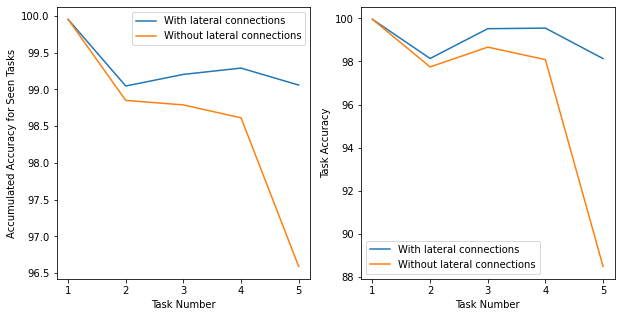

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(range(1, 6), np.nanmean(accs_a, axis=1))
ax[0].plot(range(1, 6), np.nanmean(accs_no_a, axis=1))
ax[0].legend(['With lateral connections', 'Without lateral connections'])
ax[0].set_ylabel('Accumulated Accuracy for Seen Tasks')
ax[0].set_xlabel('Task Number')

ax[1].plot(range(1, 6), accs_a[-1])
ax[1].plot(range(1, 6), accs_no_a[-1])
ax[1].legend(['With lateral connections', 'Without lateral connections'])
ax[1].set_ylabel('Task Accuracy')
ax[1].set_xlabel('Task Number')

Because we add new columns for every task, the number of parameters expands. The number of learnable parameters expands in a more modest rate as we freeze old columns. In the figure below we can see the rate at which the parameters expand. Note that because we use smaller column size starting from task 2 (32 neurons vs. 128) the learnable parameters decrease at first then increase slowly thereafter.

In [71]:
# Number of learnable paramters decreases after task#1, increase by just 66 after task#2
print(grad_parameters)

[100738, 25444, 25510, 25576, 25642]


Text(0.5, 0, 'Task Number')

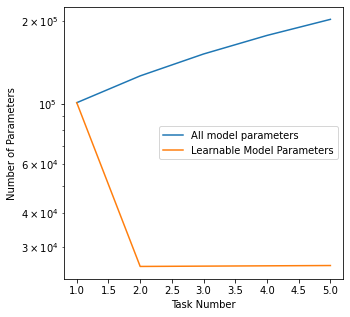

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(range(1, 6), parameters)
ax.plot(range(1, 6), grad_parameters)
ax.set_yscale('log')
ax.legend(['All model parameters', 'Learnable Model Parameters'])
ax.set_ylabel('Number of Parameters')
ax.set_xlabel('Task Number')

# Homework

In this notebook, we saw multiple ways to improve neural networks in dynamic scenarios with active learning (getting better data), adaptive experimentation (tuning hyperparameters), and continous learning (learning new tasks while not forgetting the old). In this homework you will explore each of these options with your own data and social scientific questions.

**1)** How could you use active learning in your project? (e.g., to select data to acquire or label)

In [73]:
active_learning = 'value' #@param {type:"string"}

**1a)** Implement Active Learning (in any form) using your social scientific data.

**2)** How would you use adaptive experimentation and Bayesian optimisation in your project? (e.g., to tune your model hyperparameters)

In [74]:
adaptive_learning = 'value' #@param {type:"string"}

**2a)** Implement Adaptive Experimentation in any form in a way that is related to your project or research.

**3)** How would you use adaptive experimentation and bayesian optimisation in your project? (e.g., to learn new tasks without forgetting old ones)

In [75]:
continuous_learning = 'value' #@param {type:"string"}

**3a)** Implement Continuous Learning in any form in a way that is related to your project or research.